In [3]:
# packages

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import pandas as pd
import os
from itertools import combinations
import h5py

import sys
sys.path.append("../src")
from inference import *
from analysis import *

In [4]:
import re

def natural_sort(l):
    def convert(text): return int(text) if text.isdigit() else text.lower()

    def alphanum_key(key): return [convert(c)
                                   for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)


In [5]:
# datapath = "../experiment_outputs/sdumont/growth_10_sp_10_param_seed_20_init_cond_1_rep_env_noise0.1"
datapath = "../experiment_outputs/sdumont/growth_10_sp_10_param_seed_20_init_cond_20_single_noise_cond_env_noise0.1"
log = h5py.File(f"{datapath}/data_generation_log.h5", "r")

print(f"n_species = {log.attrs['n_species']}")
print(f"avg_samp_dt = {log.attrs['avg_samp_dt']}")
print(f"env_noise = {log.attrs['env_noise']}")
print(f"meas_noise_list = {log.attrs['meas_noise_list']}")
print(f"n_params_seeds = {log.attrs['n_params_seeds']}")


n_species = [10]
avg_samp_dt = [3.  1.5 1. ]
env_noise = 0.1
meas_noise_list = [0.1]
n_params_seeds = 10


In [6]:
n_sp = 10
avg_samp_dt = 3.
env_noise = log.attrs["env_noise"]
meas_noise = 0.1
n_params_seeds = log.attrs['n_params_seeds']
params_seeds = [i.split("param_seed")[1]
                for i in os.listdir(f"{datapath}/{n_sp}_sp")]


In [7]:
def get_files(datapath, n_sp, env_noise, meas_noise, avg_samp_dt, filetype="dataset", ext="csv"):
    params_seeds = [i.split("param_seed")[1]
                    for i in os.listdir(f"{datapath}/{n_sp}_sp")]

    datafiles = []

    for p in params_seeds:
        datafiles.append(
            f"{datapath}/{n_sp}_sp/param_seed{p}/meas_noise{meas_noise}/t_samp{avg_samp_dt}/{filetype}{n_sp}_sp{p}_env_noise{env_noise}.{ext}")

    return datafiles


In [8]:
datafiles = [get_files(datapath, n_sp, env_noise, meas_noise, i)
             for i in log.attrs["avg_samp_dt"]]

inferfiles = [get_files(datapath, n_sp, env_noise, meas_noise,
                        i, "inference") for i in log.attrs["avg_samp_dt"]]

metadatafiles = [get_files(datapath, n_sp, env_noise, meas_noise,
                           i, "metadata", "txt") for i in log.attrs["avg_samp_dt"]]


In [10]:
print(f"Numbers of sampling points: {log.attrs['n_samples']}")
print(f"Average sampling intervals: {log.attrs['avg_samp_dt'].round(3)}")
print(f"Number of initial conditions: {log.attrs['n_init_cond']}")
print(f"Number of repetitions: {log.attrs['repetitions']}")
print(f"Environmental noise: {log.attrs['env_noise']}")
print(f"Amounts of measurement noise: {log.attrs['meas_noise_list']}")


Numbers of sampling points: [11 21 31]
Average sampling intervals: [3.  1.5 1. ]
Number of initial conditions: 20
Number of repetitions: 20
Environmental noise: 0.1
Amounts of measurement noise: [0.1]


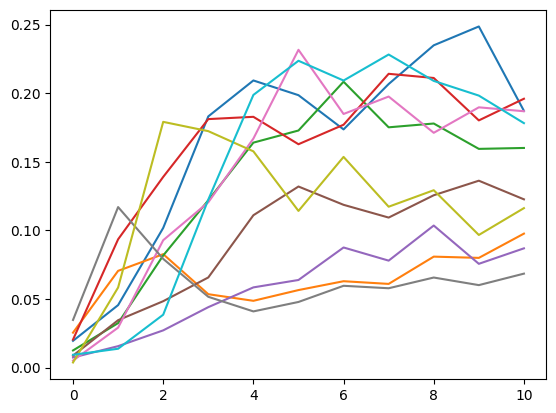

In [11]:
df = pd.read_csv(datafiles[0][0], index_col=0)
plt.plot(df[df["dataset"]==0][[i for i in df.columns if i[:2]=="sp"]])
plt.show()

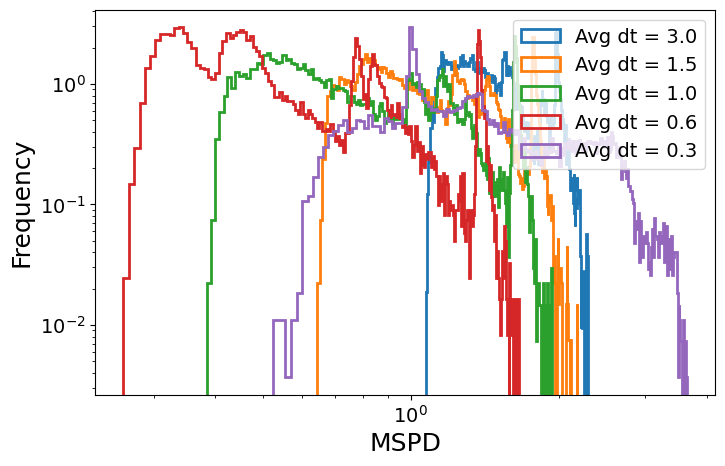

In [11]:
# MSPD frequency
plt.figure(figsize=(8, 5))
for i in range(len(log.attrs["n_samples"])):
    df = pd.concat([pd.read_csv(i, index_col=0)
                   for i in inferfiles[i]], axis=0).reset_index(drop=True)
    plt.hist(df.MSPD.values, 200,
             histtype="step", label=f"Avg dt = {log.attrs['avg_samp_dt'][i]}",
             lw=2, density=True)
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("MSPD", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale("log")
plt.yscale("log")
plt.show()


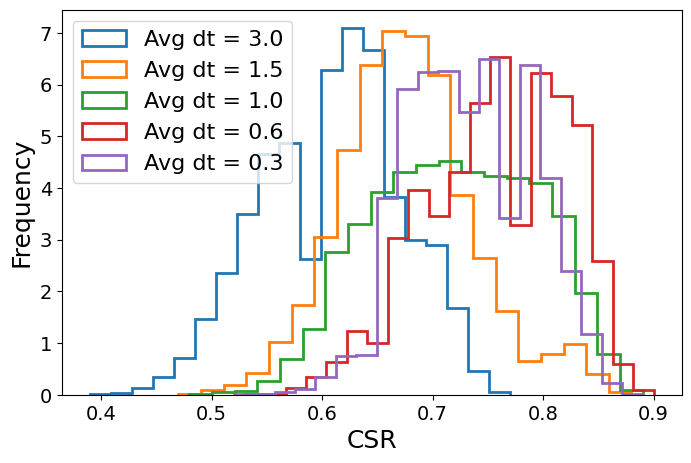

In [30]:
# CSR frequency over n_tpoints

plt.figure(figsize=(8, 5))
for i in range(len(log.attrs["n_samples"])):
    df = pd.concat([pd.read_csv(i, index_col=0)
                   for i in inferfiles[i]], axis=0).reset_index(drop=True)
    plt.hist(df.CSR.values, 20,
             histtype="step", label=f"Avg dt = {log.attrs['avg_samp_dt'][i]}",
             lw=2, density=True)
plt.legend(loc="upper left", fontsize=16)
plt.xlabel("CSR", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


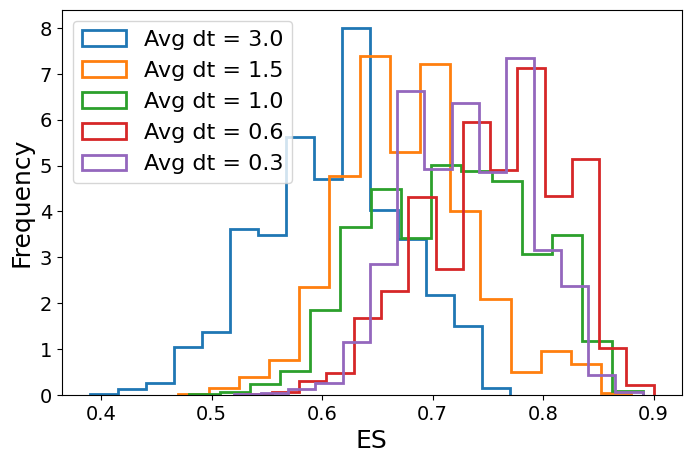

In [13]:
# ES frequency over n_tpoints

plt.figure(figsize=(8, 5))
for i in range(len(log.attrs["n_samples"])):
    df = pd.concat([pd.read_csv(i, index_col=0)
                   for i in inferfiles[i]], axis=0).reset_index(drop=True)
    plt.hist(df.ES.values, 15,
             histtype="step", label=f"Avg dt = {log.attrs['avg_samp_dt'][i]}",
             lw=2, density=True)
plt.legend(loc="upper left", fontsize=16)
plt.xlabel("ES", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


In [15]:
# Difference between CSR and ES scores
df = pd.concat([pd.read_csv(i, index_col=0)
               for i in inferfiles[0]], axis=0).reset_index(drop=True)
print((df.CSR != df.ES).sum())

0


# CSR boxplots over # of experiments
df = pd.concat([pd.read_csv(i, index_col=0)
               for i in np.concatenate(inferfiles)], axis=0).reset_index(drop=True)
CSR = [df[df.n_dset == i]["CSR"].values for i in df.n_dset.unique()]

plt.figure(figsize=(8, 5))
plt.boxplot(CSR, whis=(0, 100), meanline=True, showmeans=True)
plt.xlabel("# experiments", fontsize=18)
plt.ylabel("CSR", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


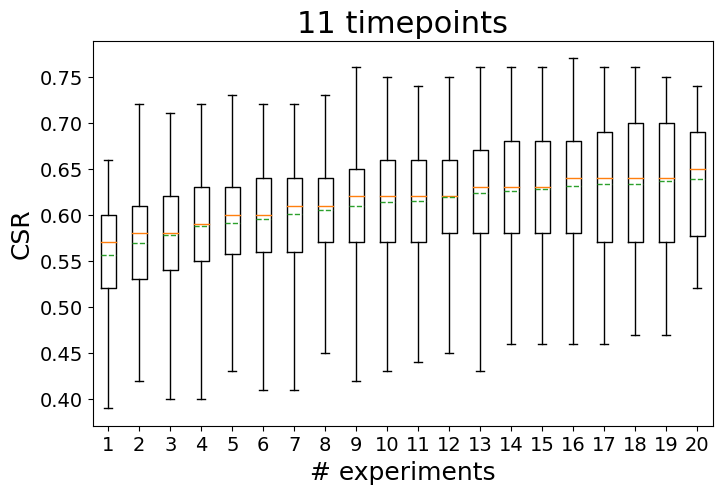

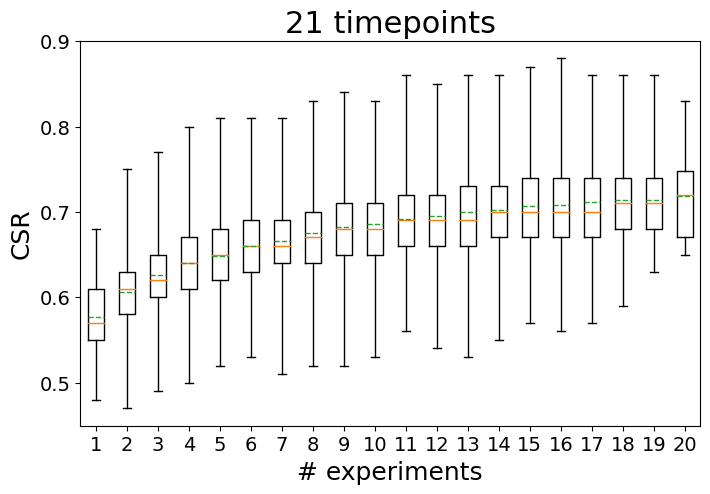

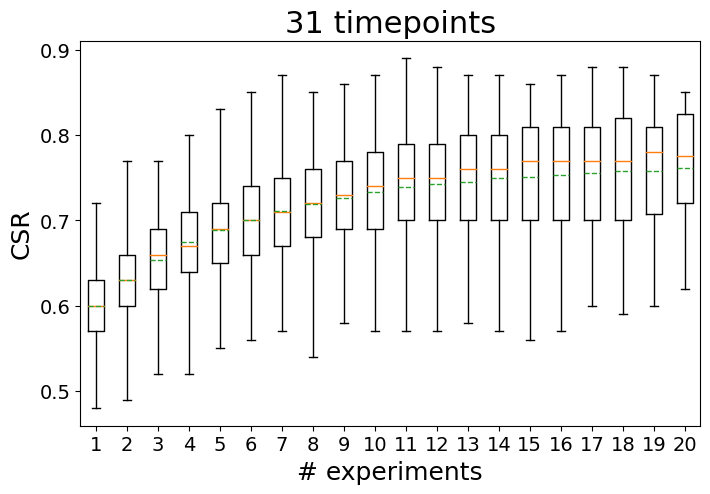

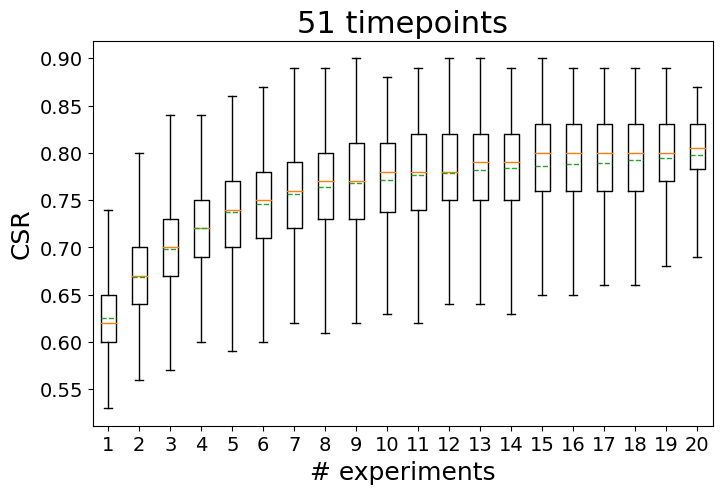

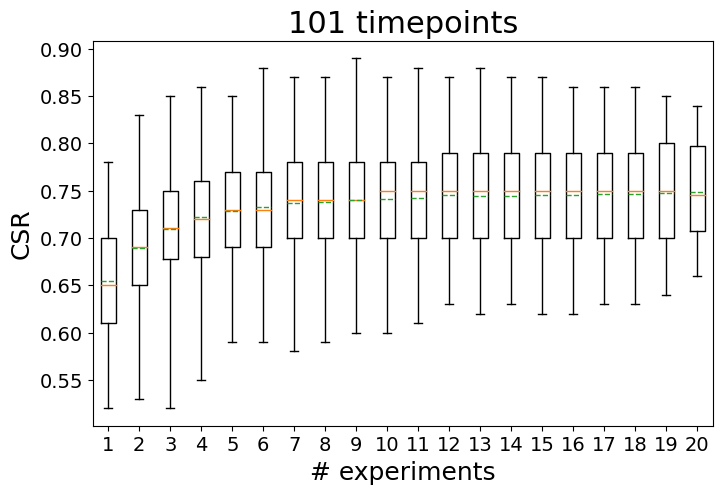

In [16]:
# CSR boxplot over # of experiments, by n_tpoints
for i in range(len(log.attrs["n_samples"])):
    df = pd.concat([pd.read_csv(i, index_col=0)
                   for i in inferfiles[i]], axis=0).reset_index(drop=True)

    CSR = [df[df["n_dset"] == i]
           ["CSR"].values for i in df.n_dset.unique()]

    plt.figure(figsize=(8, 5))
    plt.title(f"{log.attrs['n_samples'][i]} timepoints", fontsize=22)
    plt.boxplot(CSR, whis=(0, 100), meanline=True, showmeans=True)
    plt.xlabel("# experiments", fontsize=18)
    plt.ylabel("CSR", fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()


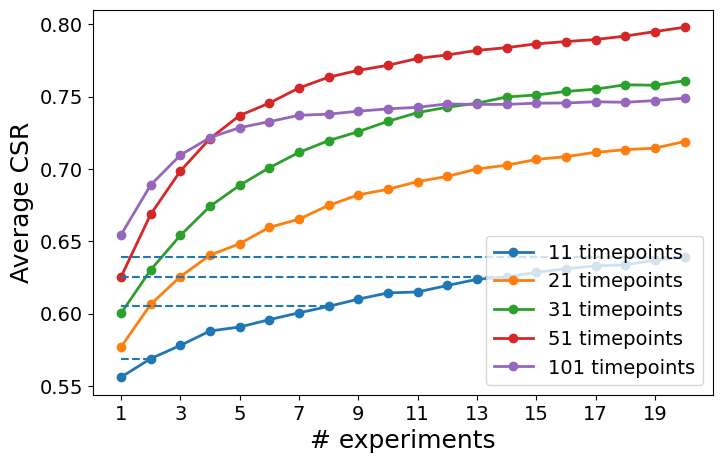

In [32]:
# average CSR over time
avgCSR = np.zeros((len(log.attrs["avg_samp_dt"]), log.attrs["n_init_cond"]))
for i in range(len(log.attrs["avg_samp_dt"])):
    df = pd.concat([pd.read_csv(k, index_col=0)
                   for k in inferfiles[i]], axis=0).reset_index(drop=True)

    for j in range(log.attrs["n_init_cond"]):
        n_dset = df["n_dset"].unique()[j]
        avgCSR[i, j] = df[df["n_dset"] ==
                          n_dset]["CSR"].values.mean()

labels = [f"{i} timepoints" for i in log.attrs["n_samples"]]
plt.figure(figsize=(8, 5))
for i in range(len(avgCSR)):
    plt.plot(np.arange(1, len(avgCSR[i])+1),
             avgCSR[i], "-o", lw=2, label=labels[i])
plt.legend(loc="lower right", fontsize=14)
plt.xlabel("# experiments", fontsize=18)
plt.ylabel("Average CSR", fontsize=18)
plt.xticks(np.arange(1, len(CSR)+1, 2), fontsize=14)
plt.yticks(fontsize=14)
for i in range(1, len(avgCSR[0]), 6):
    plt.hlines(avgCSR[0, i], 1, i+1, color="C0", ls="--")
    # plt.hlines(avgCSR[1,i], 1, i+1, color="C1")
# plt.savefig("avg_csr_vs_#exp.png", dpi=300, bbox_inches="tight")
# plt.show()


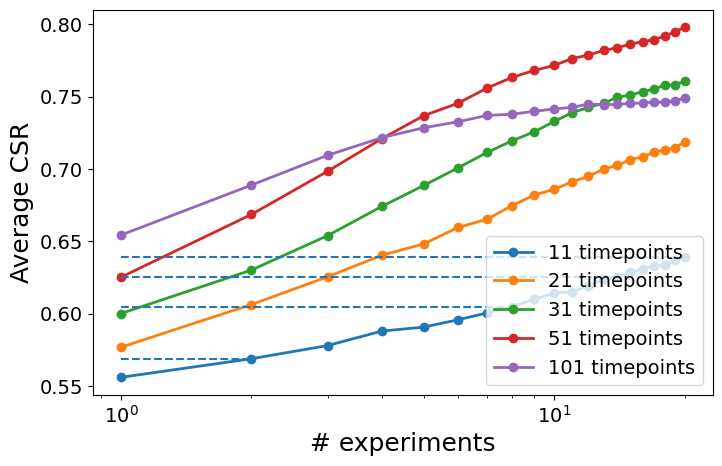

In [18]:
# average CSR over time
avgCSR = np.zeros((len(log.attrs["avg_samp_dt"]), log.attrs["n_init_cond"]))
for i in range(len(log.attrs["avg_samp_dt"])):
    df = pd.concat([pd.read_csv(k, index_col=0)
                   for k in inferfiles[i]], axis=0).reset_index(drop=True)

    for j in range(log.attrs["n_init_cond"]):
        n_dset = df["n_dset"].unique()[j]
        avgCSR[i, j] = df[df["n_dset"] ==
                          n_dset]["CSR"].values.mean()

labels = [f"{i} timepoints" for i in log.attrs["n_samples"]]
plt.figure(figsize=(8, 5))
for i in range(len(avgCSR)):
    plt.plot(np.arange(1, len(avgCSR[i])+1),
             avgCSR[i], "-o", lw=2, label=labels[i])
plt.legend(loc="lower right", fontsize=14)
plt.xlabel("# experiments", fontsize=18)
plt.ylabel("Average CSR", fontsize=18)
plt.xticks(np.arange(1, len(CSR)+1, 2), fontsize=14)
plt.yticks(fontsize=14)
for i in range(1, len(avgCSR[0]), 6):
    plt.hlines(avgCSR[0, i], 1, i+1, color="C0", ls="--")
    # plt.hlines(avgCSR[1,i], 1, i+1, color="C1")
plt.xscale("log")
# plt.savefig("avg_csr_vs_#exp_xscale_log.png", dpi=300, bbox_inches="tight")
# plt.show()


In [50]:
df_ = pd.read_csv(datafiles[0][0])

df_[df_["init_cond_idx"]==1]

Unnamed: 0  dataset  init_cond_idx  t_samp_dist_idx  measurement_noise  \
11          11      1.0            1.0              0.0                0.1   
12          12      1.0            1.0              0.0                0.1   
13          13      1.0            1.0              0.0                0.1   
14          14      1.0            1.0              0.0                0.1   
15          15      1.0            1.0              0.0                0.1   
16          16      1.0            1.0              0.0                0.1   
17          17      1.0            1.0              0.0                0.1   
18          18      1.0            1.0              0.0                0.1   
19          19      1.0            1.0              0.0                0.1   
20          20      1.0            1.0              0.0                0.1   
21          21      1.0            1.0              0.0                0.1   

    replicate  time   dt       sp1       sp2       sp3       sp4       sp5  \
11        0.0   0.0  3.0  0.015705  0.004535  0.024089  0.018538  0.027020   
12        0.0   3.0  3.0  0.079680  0.015816  0.106629  0.050139  0.039748   
13        0.0   6.0  3.0  0.162215  0.030796  0.150125  0.107378  0.048803   
14        0.0   9.0  3.0  0.226812  0.037717  0.208608  0.185122  0.067359   
15        0.0  12.0  3.0  0.198459  0.052086  0.226605  0.240438  0.066484   
16        0.0  15.0  3.0  0.248935  0.050628  0.167704  0.203634  0.066169   
17        0.0  18.0  3.0  0.247427  0.093568  0.194724  0.224622  0.066567   
18        0.0  21.0  3.0  0.205926  0.107988  0.201645  0.189167  0.052846   
19        0.0  24.0  3.0  0.241510  0.082742  0.239436  0.227100  0.054651   
20        0.0  27.0  3.0  0.230638  0.072202  0.168348  0.256953  0.083672   
21        0.0  30.0  NaN  0.288956  0.098570  0.138955  0.197208  0.098547   

         sp6       sp7       sp8       sp9      sp10  
11  0.015267  0.009545  0.011826  0.020004  0.016294  
12  0.043529  0.027298  0.044470  0.155587  0.040169  
13  0.097220  0.075041  0.049806  0.249200  0.087045  
14  0.113159  0.128103  0.050442  0.179338  0.163454  
15  0.107925  0.189769  0.058830  0.179280  0.230375  
16  0.146084  0.204076  0.043947  0.169149  0.226072  
17  0.153173  0.246744  0.051469  0.114612  0.274186  
18  0.134986  0.235166  0.066701  0.114645  0.276432  
19  0.129428  0.217542  0.068020  0.157342  0.269214  
20  0.102010  0.211468  0.069598  0.123228  0.247847  
21  0.167194  0.176630  0.070229  0.129434  0.235481

In [37]:
df.init_cond_idx.unique()

array(['[8.]', '[4.]', '[19.]', ...,
       '[10.  5.  8.  3. 18. 16. 17. 19.  6.  0.  7.  1.  4. 14. 13.  2. 15.  9.\n 11.]',
       '[16.  9. 19.  3.  2.  0.  4.  1. 12. 11. 13.  5.  6. 10.  7. 14. 17. 18.\n 15.]',
       '[ 2.  6.  9. 14. 10. 19.  8.  0. 16. 17.  4. 15.  5. 13.  3. 12.  7.  1.\n 18. 11.]'],
      dtype=object)

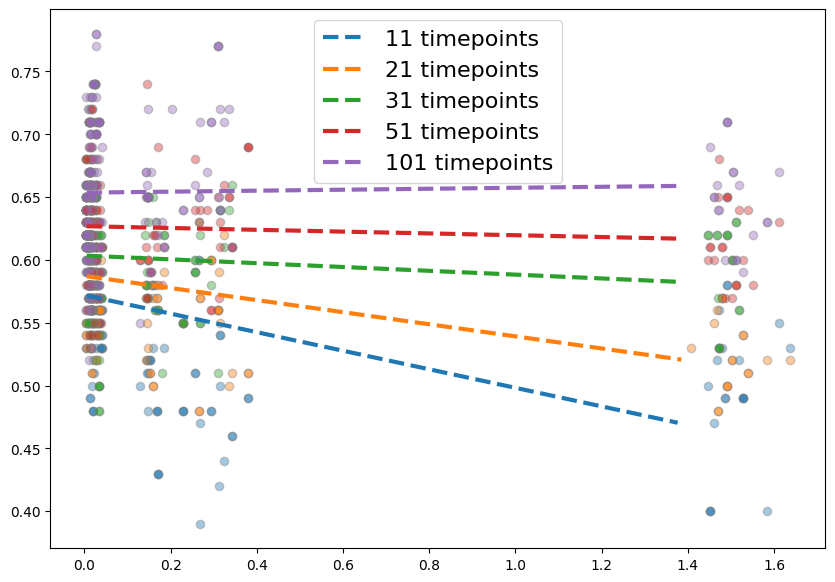

In [34]:
plt.figure(figsize=(10, 7))

for j in range(len(log.attrs["n_samples"])):
    init_cond_msd = []
    csr = []

    for p in range(log.attrs["n_params_seeds"]):
        df = pd.read_csv(inferfiles[j][p], index_col=0)

        metadict = get_meta(open(metadatafiles[j][p], "r").read().split("\n"))

        df_tmp = df[df["n_dset"] == 1]

        init_cond_idx = [int(re.findall("([0-9]+).", i)[0])
                         for i in df_tmp.init_cond_idx]
        init_cond = metadict["init_cond"][init_cond_idx]

        p = metadict["parameters"]
        r = p[:n_sp]
        A = p[n_sp:].reshape((n_sp, n_sp))
        x_eq = -np.linalg.inv(A)@r

        init_cond_msd.append(((init_cond-x_eq)**2).mean(axis=1))
        # init_cond_msd.append(np.dot(init_cond,x_eq))
        csr.append(df_tmp.CSR.values)

        plt.scatter(np.dot(init_cond,x_eq), df_tmp.CSR,
                    facecolors=f"C{j}", alpha=0.4, edgecolors="gray")

    init_cond_msd = np.concatenate(init_cond_msd)
    csr = np.concatenate(csr)

    reg = lm.LinearRegression()
    reg.fit((init_cond_msd).reshape((-1, 1)), csr)
    plt.plot([(init_cond_msd).min(), (init_cond_msd).max()],
             reg.predict([[(init_cond_msd).min()],
                         [(init_cond_msd).max()]]),
             ls="--", lw=3, c=f"C{j}", label=f"{metadict['n_tpoints'][j]} timepoints")

# plt.xlabel()
plt.legend(fontsize=16)
plt.show()


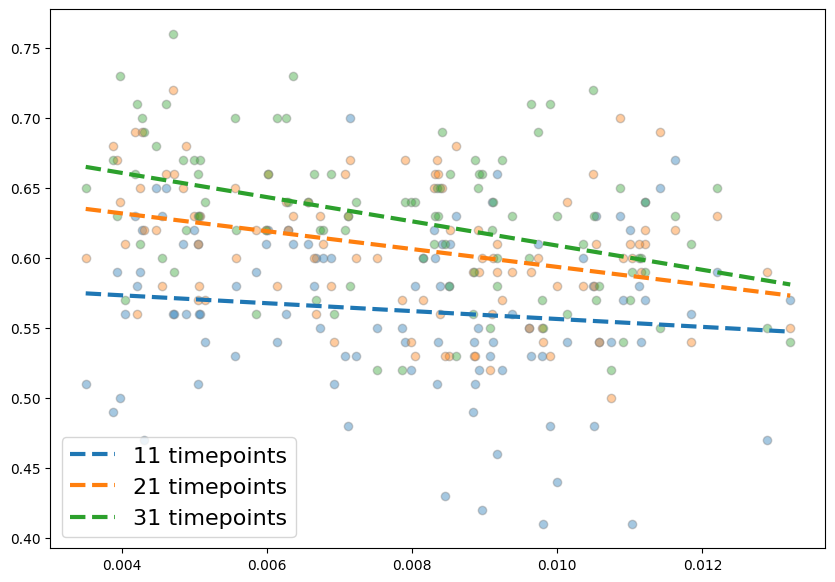

In [ ]:
plt.figure(figsize=(10, 7))

for j in range(len(log.attrs["n_samples"])):
    init_cond_msd = []
    csr = []

    for p in range(log.attrs["n_params_seeds"]):
        df = pd.read_csv(inferfiles[j][p], index_col=0)

        metadict = get_meta(open(metadatafiles[j][p], "r").read().split("\n"))

        df_tmp = df[df["n_init_cond"] == 1]

        init_cond_idx = [int(re.findall("([0-9]+).0", i)[0])
                         for i in df_tmp.init_cond_idx]
        init_cond = metadict["init_cond"][init_cond_idx]

        p = metadict["parameters"]
        r = p[:n_sp]
        A = p[n_sp:].reshape((n_sp, n_sp))
        x_eq = -np.linalg.inv(A)@r

        init_cond_msd.append(((init_cond/init_cond.sum(0)-x_eq/x_eq.sum())**2).mean(axis=1))
        # init_cond_msd.append(np.dot(init_cond/init_cond.sum(0),x_eq/x_eq.sum()))
        csr.append(df_tmp.CSR.values)

        plt.scatter(((init_cond/init_cond.sum(0)-x_eq/x_eq.sum())**2).mean(axis=1), df_tmp.CSR,
                    facecolors=f"C{j}", alpha=0.4, edgecolors="gray")

    init_cond_msd = np.concatenate(init_cond_msd)
    csr = np.concatenate(csr)

    reg = lm.LinearRegression()
    reg.fit((init_cond_msd).reshape((-1, 1)), csr)
    plt.plot([(init_cond_msd).min(), (init_cond_msd).max()],
             reg.predict([[(init_cond_msd).min()],
                         [(init_cond_msd).max()]]),
             ls="--", lw=3, c=f"C{j}", label=f"{metadict['n_tpoints'][j]} timepoints")

# plt.xlabel()
plt.legend(fontsize=16)
plt.show()


In [ ]:
def dot_mean(m):
    avg_cos = 0
    avg_norm_prod = 0
    n = 0
    for i in range(len(m)-1):
        for j in range(i+1, len(m)):
            n += 1
            avg_cos += (m[i].dot(m[j])/(np.linalg.norm(m[i])
                        * np.linalg.norm(m[j]))-avg_cos)/n
            # avg_dot += (m[i].dot(m[j])-avg_dot)/n
            # avg_cos += (np.linalg.norm(m[i]-m[j])-avg_dot)/n
            avg_norm_prod += (np.linalg.norm(m[i])
                              * np.linalg.norm(m[j])-avg_norm_prod)/n

    return avg_cos, avg_norm_prod


In [ ]:
def distances(m):
    n = 0
    avg_dist = 0
    for i in range(m.shape[0]-1):
        for j in range(i+1, m.shape[0]):
            n += 1
            avg_dist += (np.linalg.norm(m[i]-m[j])-avg_dist)/n

    return avg_dist


In [ ]:
np.linalg.norm(init_cond, axis=1).shape

(19,)

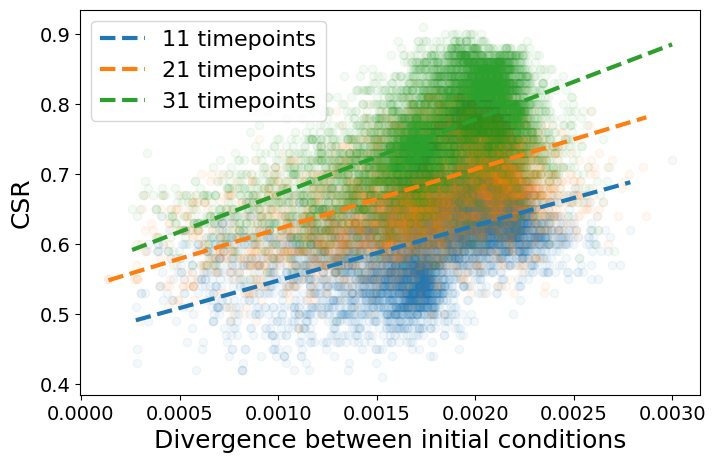

In [ ]:
plt.figure(figsize=(8, 5))

# for j in range(2, 3):
for j in range(len(log.attrs["n_samples"])):
    total_init_cond_dot = []
    total_csr = []

    for p in range(log.attrs["n_params_seeds"]):
        df = pd.read_csv(inferfiles[j][p], index_col=0)

        metadict = get_meta(open(metadatafiles[j][p], "r").read().split("\n"))

        p = metadict["parameters"]
        r = p[:n_sp]
        A = p[n_sp:].reshape((n_sp, n_sp))
        x_eq = -np.linalg.inv(A)@r

        for n in range(2, 20):
            df_tmp = df[df["n_dset"] == n]

            init_cond_idx = [[int(m) for m in re.findall("([0-9]+).", i)]
                             for i in df_tmp.init_cond_idx.values]

            init_cond_x_eq_dot_mean = []
            csr = []

            for l in range(len(init_cond_idx)):
                init_cond = metadict["init_cond"][init_cond_idx[l]]

                # init_cond_x_eq = init_cond#/np.sqrt((init_cond**2).sum(axis=0))#-x_eq/x_eq.sum()
                # init_cond_x_eq = (init_cond / \
                #     init_cond.sum(axis=1).reshape((-1,1)))[1:]-(init_cond / \
                #     init_cond.sum(axis=1).reshape((-1,1)))[0]
                init_cond_x_eq = init_cond / \
                    init_cond.sum(axis=1).reshape((-1,1))-(init_cond / \
                    init_cond.sum(axis=1).reshape((-1,1))).mean(0)
                # init_cond_x_eq = init_cond / \
                #     i15,16nit_cond.sum(axis=1).reshape((-1,1))-x_eq/x_eq.sum()
                # init_cond_x_eq /= np.linalg.norm(init_cond_x_eq,
                                                #  axis=1).reshape((-1, 1))

                # init_cond_x_eq_dot_mean.append(distances(init_cond_x_eq))
                init_cond_x_eq_dot_mean.append((init_cond_x_eq**2).mean())
                # init_cond_x_eq_dot_mean.append((np.linalg.norm(init_cond_x_eq, axis=1)**2).mean())
                # init_cond_x_eq_dot_mean.append(dot_mean(init_cond_x_eq)[0])
                csr.append(df_tmp.CSR.values[l])

            init_cond_x_eq_dot_mean = np.array(init_cond_x_eq_dot_mean)
            csr = np.array(csr)

            total_init_cond_dot.append(init_cond_x_eq_dot_mean)
            total_csr.append(csr)

    total_init_cond_dot = np.concatenate(total_init_cond_dot)
    total_csr = np.concatenate(total_csr)

    dot_avg = []
    for i in np.unique(total_csr):
        dot_avg.append(total_init_cond_dot[np.where(total_csr==i)].mean())

    # plt.plot(dot_avg, np.unique(total_csr), "-o")

    plt.scatter((total_init_cond_dot), total_csr,
                c=f"C{j}", alpha=0.05)

    reg = lm.LinearRegression()
    reg.fit((total_init_cond_dot).reshape((-1, 1)), total_csr)
    plt.plot([(total_init_cond_dot).min(), (total_init_cond_dot).max()],
             reg.predict([[(total_init_cond_dot).min()],
                         [(total_init_cond_dot).max()]]),
             ls="--", lw=3, c=f"C{j}", label=f"{metadict['n_tpoints'][j]} timepoints")

plt.xlabel("Divergence between initial conditions", fontsize=18)
plt.ylabel("CSR", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
# plt.xscale("log")
# plt.show()
plt.savefig("csr_vs_init_cond_dot.png", dpi=300, bbox_inches="tight")


(array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 [Text(0, 0.4, '0.4'),
  Text(0, 0.5, '0.5'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.7000000000000001, '0.7'),
  Text(0, 0.8, '0.8'),
  Text(0, 0.9, '0.9'),
  Text(0, 1.0, '1.0')])

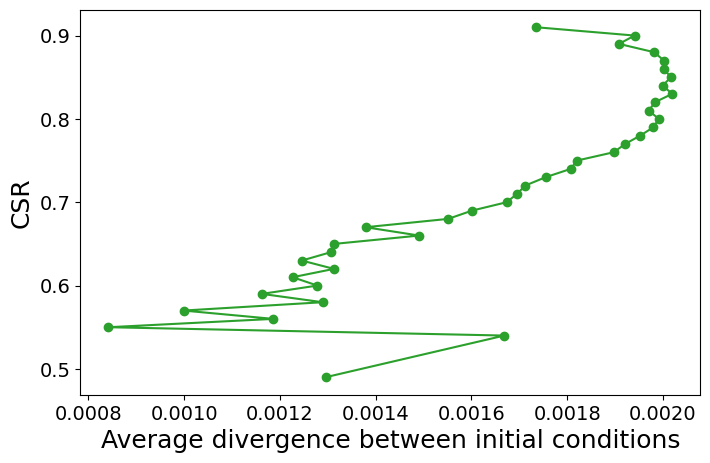

In [ ]:
dot_avg = []
for i in np.unique(total_csr):
    dot_avg.append(total_init_cond_dot[np.where(total_csr==i)].mean())

plt.figure(figsize=(8, 5))
plt.plot(dot_avg, np.unique(total_csr), "-o", c="C2")
plt.xlabel("Average divergence between initial conditions", fontsize=18)
plt.ylabel("CSR", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.savefig("csr_vs_avg_init_cond_dot.png", dpi=300, bbox_inches="tight")

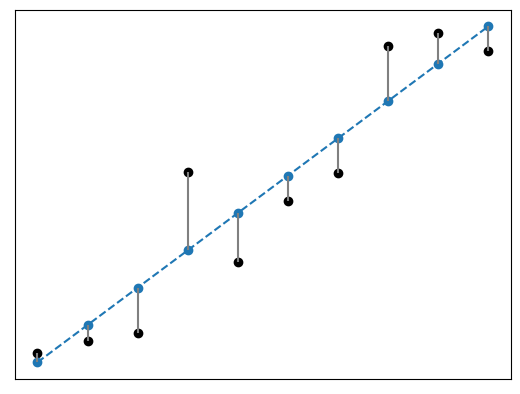

In [ ]:
np.random.seed(124)
l = np.linspace(0, 1, 10)
ll = l+np.random.normal(scale=0.1, size=l.shape[0])
plt.plot(l, l, "--o")
plt.scatter(l, ll, c="k")
for i in range(len(l)):
    plt.vlines(l[i], min(l[i], ll[i]), max(l[i], ll[i]), color="gray")
plt.xticks([])
plt.yticks([])
plt.savefig("lr_residues.png", dpi=300, bbox_inches="tight")

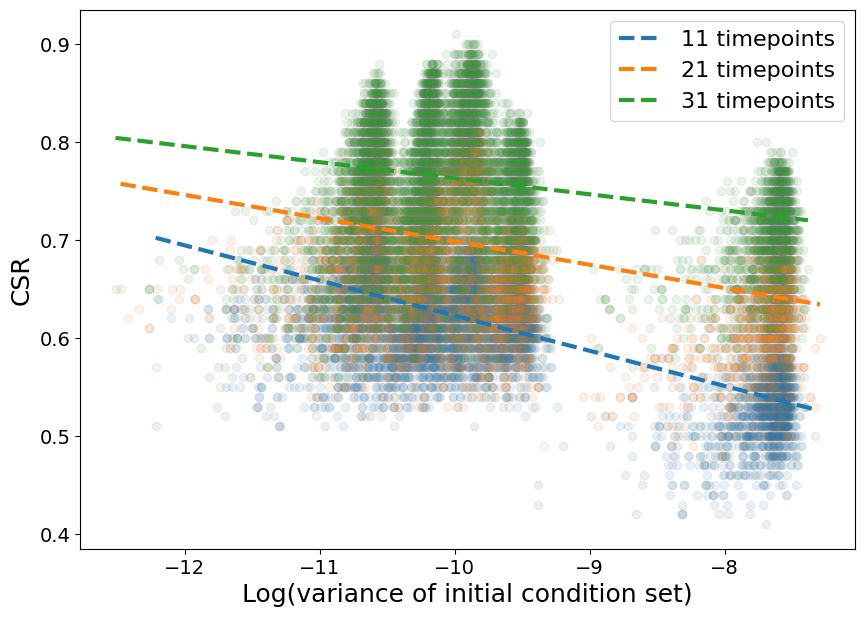

In [ ]:
plt.figure(figsize=(10, 7))

for j in range(len(log.attrs["n_samples"])):
    total_init_cond_var = []
    total_csr = []

    for p in range(log.attrs["n_params_seeds"]):
        df = pd.read_csv(inferfiles[j][p], index_col=0)

        metadict = get_meta(open(metadatafiles[j][p], "r").read().split("\n"))

        p = metadict["parameters"]
        r = p[:n_sp]
        A = p[n_sp:].reshape((n_sp, n_sp))
        x_eq = -np.linalg.inv(A)@r

        for n in range(2, 20):
            df_tmp = df[df["n_dset"] == n]

            init_cond_idx = [[int(m) for m in re.findall("([0-9]+).", i)]
                             for i in df_tmp.init_cond_idx.values]

            init_cond_var = []
            csr = []

            for l in range(len(init_cond_idx)):
                init_cond = metadict["init_cond"][init_cond_idx[l]]

                init_cond_var.append(init_cond-x_eq/10)
                csr.append(df_tmp.CSR.values[l])

            init_cond_var = np.array(init_cond_var).var(axis=1).mean(axis=1)
            csr = np.array(csr)

            total_init_cond_var.append(init_cond_var)
            total_csr.append(csr)

    total_init_cond_var = np.concatenate(total_init_cond_var)
    total_csr = np.concatenate(total_csr)

    plt.scatter(np.log(total_init_cond_var), total_csr,
                c=f"C{j}", alpha=0.1, edgecolors="gray")

    reg = lm.LinearRegression()
    reg.fit(np.log(total_init_cond_var).reshape((-1, 1)), total_csr)
    plt.plot([np.log(total_init_cond_var).min(), np.log(total_init_cond_var).max()],
             reg.predict([[np.log(total_init_cond_var).min()],
                         [np.log(total_init_cond_var).max()]]),
             ls="--", lw=3, c=f"C{j}", label=f"{metadict['n_tpoints'][j]} timepoints")

plt.xlabel("Log(variance of initial condition set)", fontsize=18)
plt.ylabel("CSR", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()


In [ ]:
# CSR ratios

tpoints_ratio01 = []
CSR_ratio01 = []
tpoints_ratio02 = []
CSR_ratio02 = []
tpoints_ratio12 = []
CSR_ratio12 = []

for i in range(len(avgCSR[0])):
    for j in range(len(avgCSR[1])):
        tpoints_ratio01.append(20*(j+1)/(10*(i+1)))
        CSR_ratio01.append(avgCSR[1, j]/avgCSR[0, i])
        tpoints_ratio02.append(30*(j+1)/(10*(i+1)))
        CSR_ratio02.append(avgCSR[2, j]/avgCSR[0, i])
        tpoints_ratio12.append(30*(j+1)/(20*(i+1)))
        CSR_ratio12.append(avgCSR[2, j]/avgCSR[1, i])

tpoints_ratio01 = np.array(tpoints_ratio01)
CSR_ratio01 = np.array(CSR_ratio01)
tpoints_ratio02 = np.array(tpoints_ratio02)
CSR_ratio02 = np.array(CSR_ratio02)
tpoints_ratio12 = np.array(tpoints_ratio12)
CSR_ratio12 = np.array(CSR_ratio12)

tpoints_ratio = np.concatenate(
    (tpoints_ratio01, tpoints_ratio02, tpoints_ratio12))
CSR_ratio = np.concatenate((CSR_ratio01, CSR_ratio02, CSR_ratio12))


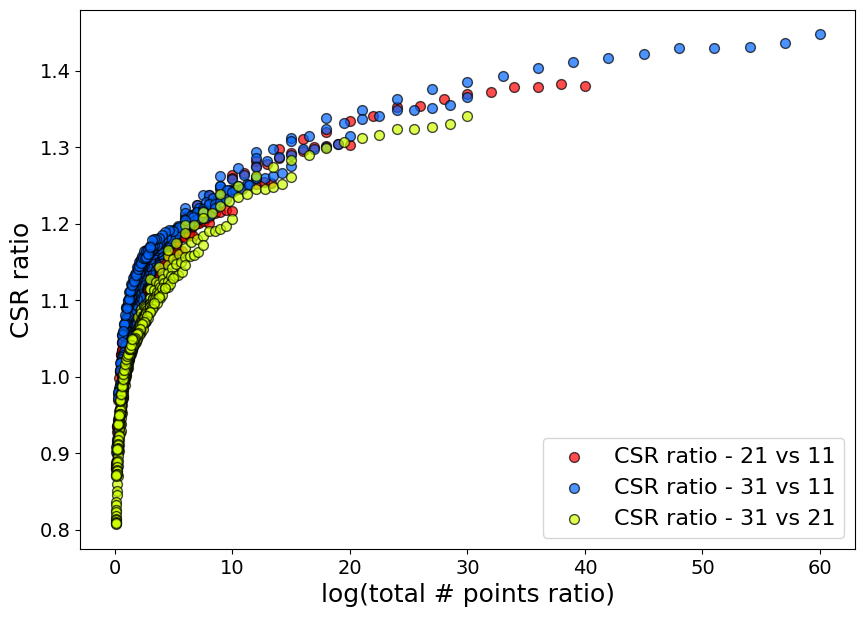

In [ ]:
# CSR_ratio vs tpoints ratio
plt.figure(figsize=(10, 7))

# 01 ---
plt.scatter(tpoints_ratio01, CSR_ratio01, facecolors=hsv_to_rgb((0, 1, 1)), edgecolors="k",
            label="CSR ratio - 21 vs 11", s=50, alpha=0.7)

# 02 ---
plt.scatter(tpoints_ratio02, CSR_ratio02, facecolors=hsv_to_rgb((0.6, 1, 1)), edgecolors="k",
            label="CSR ratio - 31 vs 11", s=50, alpha=0.7)

# 12 ---
plt.scatter(tpoints_ratio12, CSR_ratio12, facecolors=hsv_to_rgb((0.2, 1, 1)), edgecolors="k",
            label="CSR ratio - 31 vs 21", s=50, alpha=0.7)

plt.xlabel("log(total # points ratio)", fontsize=18)
plt.ylabel("CSR ratio", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()


20 vs 10 timepoints:
CSR_ratio vs log(tpoints_ratio): R2 score = 0.9688767229130073
intercept = 1.05299, slope = 0.08300

--------------------------------
30 vs 10 timepoints:
CSR_ratio vs log(tpoints_ratio): R2 score = 0.9690316284376577
intercept = 1.06076, slope = 0.08633

--------------------------------
30 vs 20 timepoints:
CSR_ratio vs log(tpoints_ratio): R2 score = 0.9792481809945422
intercept = 1.01010, slope = 0.08642

--------------------------------
all ratios:
CSR_ratio vs log(tpoints_ratio): R2 score = 0.9363564622468928
intercept = 1.03817, slope = 0.08954


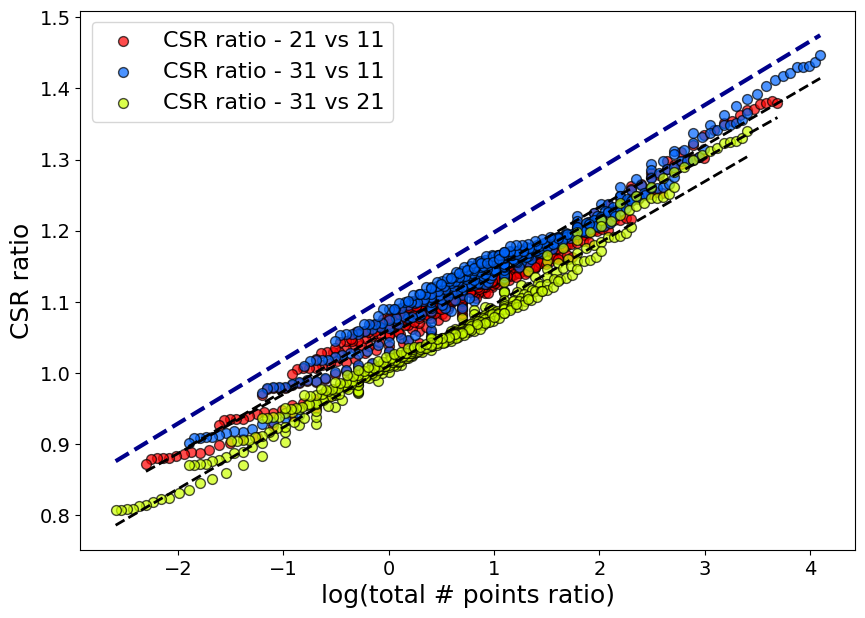

In [ ]:
# CSR_ratio vs log(tpoints ratio)
plt.figure(figsize=(10, 7))

# 01 ---
plt.scatter(np.log(tpoints_ratio01), CSR_ratio01, facecolors=hsv_to_rgb((0, 1, 1)), edgecolors="k",
            label="CSR ratio - 21 vs 11", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio01).reshape((-1, 1)), CSR_ratio01)
x_ext = np.array([np.min(np.log(tpoints_ratio01)),
                 np.max(np.log(tpoints_ratio01))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1, 1))), c="k", lw=2, ls="--")

print("20 vs 10 timepoints:")
print("CSR_ratio vs log(tpoints_ratio): R2 score =", reg.score(
    np.log(tpoints_ratio01).reshape((-1, 1)), CSR_ratio01))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

# 02 ---
plt.scatter(np.log(tpoints_ratio02), CSR_ratio02, facecolors=hsv_to_rgb((0.6, 1, 1)), edgecolors="k",
            label="CSR ratio - 31 vs 11", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio02).reshape((-1, 1)), CSR_ratio02)
x_ext = np.array([np.min(np.log(tpoints_ratio02)),
                 np.max(np.log(tpoints_ratio02))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1, 1))), c="k", lw=2, ls="--")

print("\n--------------------------------")
print("30 vs 10 timepoints:")
print("CSR_ratio vs log(tpoints_ratio): R2 score =", reg.score(
    np.log(tpoints_ratio02).reshape((-1, 1)), CSR_ratio02))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

# 12 ---
plt.scatter(np.log(tpoints_ratio12), CSR_ratio12, facecolors=hsv_to_rgb((0.2, 1, 1)), edgecolors="k",
            label="CSR ratio - 31 vs 21", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio12).reshape((-1, 1)), CSR_ratio12)
x_ext = np.array([np.min(np.log(tpoints_ratio12)),
                 np.max(np.log(tpoints_ratio12))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1, 1))), c="k", lw=2, ls="--")

print("\n--------------------------------")
print("30 vs 20 timepoints:")
print("CSR_ratio vs log(tpoints_ratio): R2 score =", reg.score(
    np.log(tpoints_ratio12).reshape((-1, 1)), CSR_ratio12))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio).reshape((-1, 1)), CSR_ratio)
x_ext = np.array([np.min(np.log(tpoints_ratio)),
                 np.max(np.log(tpoints_ratio))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1, 1))) +
         0.07, c="darkblue", lw=3, ls="--")

print("\n--------------------------------")
print("all ratios:")
print("CSR_ratio vs log(tpoints_ratio): R2 score =", reg.score(
    np.log(tpoints_ratio).reshape((-1, 1)), CSR_ratio))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

plt.xlabel("log(total # points ratio)", fontsize=18)
plt.ylabel("CSR ratio", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()


20 vs 10 timepoints:
log(CSR_ratio) vs log(tpoints_ratio): R2 score = 0.9663976319436155
intercept = 0.04911, slope = 0.07513

--------------------------------
30 vs 10 timepoints:
log(CSR_ratio) vs log(tpoints_ratio): R2 score = 0.9655287621278139
intercept = 0.05843, slope = 0.07514

--------------------------------
30 vs 20 timepoints:
log(CSR_ratio) vs log(tpoints_ratio): R2 score = 0.9845238204670156
intercept = 0.00628, slope = 0.08266

--------------------------------
all ratios:
log(CSR_ratio) vs log(tpoints_ratio): R2 score = 0.9335662021826787
intercept = 0.03423, slope = 0.08159


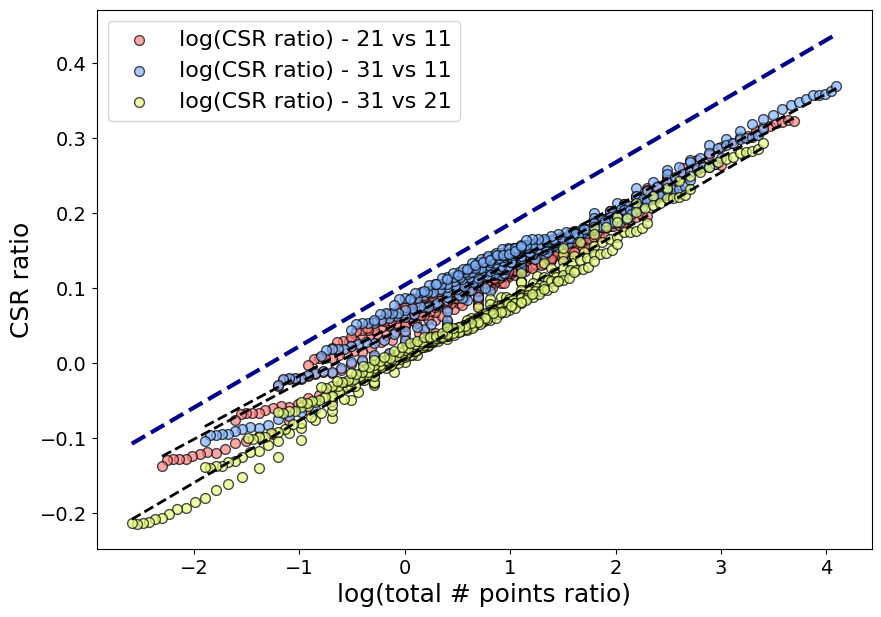

In [ ]:
# log(CSR_ratio) vs log(tpoints_ratio)

plt.figure(figsize=(10, 7))

# 01 ---
plt.scatter(np.log(tpoints_ratio01), np.log(CSR_ratio01), facecolors=hsv_to_rgb((0, 0.5, 1)), edgecolors="k",
            label="log(CSR ratio) - 21 vs 11", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio01).reshape((-1, 1)), np.log(CSR_ratio01))
x_ext = np.array([np.min(np.log(tpoints_ratio01)),
                 np.max(np.log(tpoints_ratio01))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1, 1))), c="k", lw=2, ls="--")

print("20 vs 10 timepoints:")
print("log(CSR_ratio) vs log(tpoints_ratio): R2 score =", reg.score(
    np.log(tpoints_ratio01).reshape((-1, 1)), np.log(CSR_ratio01)))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

# 02 ---
plt.scatter(np.log(tpoints_ratio02), np.log(CSR_ratio02), facecolors=hsv_to_rgb((0.6, 0.5, 1)), edgecolors="k",
            label="log(CSR ratio) - 31 vs 11", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio02).reshape((-1, 1)), np.log(CSR_ratio02))
x_ext = np.array([np.min(np.log(tpoints_ratio02)),
                 np.max(np.log(tpoints_ratio02))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1, 1))), c="k", lw=2, ls="--")

print("\n--------------------------------")
print("30 vs 10 timepoints:")
print("log(CSR_ratio) vs log(tpoints_ratio): R2 score =", reg.score(
    np.log(tpoints_ratio02).reshape((-1, 1)), np.log(CSR_ratio02)))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

# 12 ---
plt.scatter(np.log(tpoints_ratio12), np.log(CSR_ratio12), facecolors=hsv_to_rgb((0.2, 0.5, 1)), edgecolors="k",
            label="log(CSR ratio) - 31 vs 21", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio12).reshape((-1, 1)), np.log(CSR_ratio12))
x_ext = np.array([np.min(np.log(tpoints_ratio12)),
                 np.max(np.log(tpoints_ratio12))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1, 1))), c="k", lw=2, ls="--")

print("\n--------------------------------")
print("30 vs 20 timepoints:")
print("log(CSR_ratio) vs log(tpoints_ratio): R2 score =", reg.score(
    np.log(tpoints_ratio12).reshape((-1, 1)), np.log(CSR_ratio12)))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio).reshape((-1, 1)), np.log(CSR_ratio))
x_ext = np.array([np.min(np.log(tpoints_ratio)),
                 np.max(np.log(tpoints_ratio))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1, 1))) +
         0.07, c="darkblue", lw=3, ls="--")

print("\n--------------------------------")
print("all ratios:")
print("log(CSR_ratio) vs log(tpoints_ratio): R2 score =", reg.score(
    np.log(tpoints_ratio).reshape((-1, 1)), np.log(CSR_ratio)))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

plt.xlabel("log(total # points ratio)", fontsize=18)
plt.ylabel("CSR ratio", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()


R2 score = 0.6099234307722248


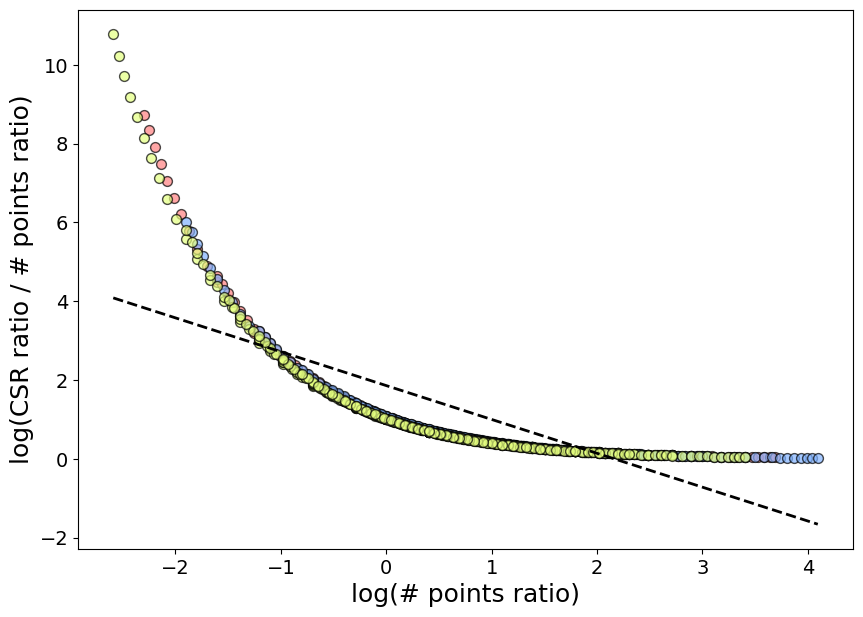

In [ ]:
# CSR_ratio/tpoints_ratio vs log(tpoints_ratio)

plt.figure(figsize=(10, 7))

plt.scatter(np.log(tpoints_ratio01), CSR_ratio01/tpoints_ratio01,
            facecolors=hsv_to_rgb((0, 0.5, 1)), edgecolors="k", s=50, alpha=0.7)

plt.scatter(np.log(tpoints_ratio02), CSR_ratio02/tpoints_ratio02,
            facecolors=hsv_to_rgb((0.6, 0.5, 1)), edgecolors="k", s=50, alpha=0.7)

plt.scatter(np.log(tpoints_ratio12), CSR_ratio12/tpoints_ratio12,
            facecolors=hsv_to_rgb((0.2, 0.5, 1)), edgecolors="k", s=50, alpha=0.7)

reg = lm.LinearRegression()
tpoints_ratio = np.concatenate(
    (tpoints_ratio01, tpoints_ratio02, tpoints_ratio12))
CSR_ratio = np.concatenate((CSR_ratio01, CSR_ratio02, CSR_ratio12))
reg.fit(np.log(tpoints_ratio).reshape((-1, 1)), CSR_ratio/tpoints_ratio)
x_ext = np.array([np.min(np.log(tpoints_ratio)),
                 np.max(np.log(tpoints_ratio))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1, 1)))+0.3, c="k", lw=2, ls="--")

print("R2 score =", reg.score(
    np.log(tpoints_ratio).reshape((-1, 1)), CSR_ratio/tpoints_ratio))

plt.xlabel("log(# points ratio)", fontsize=18)
plt.ylabel("log(CSR ratio / # points ratio)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


R2 score = 0.9994387195519443


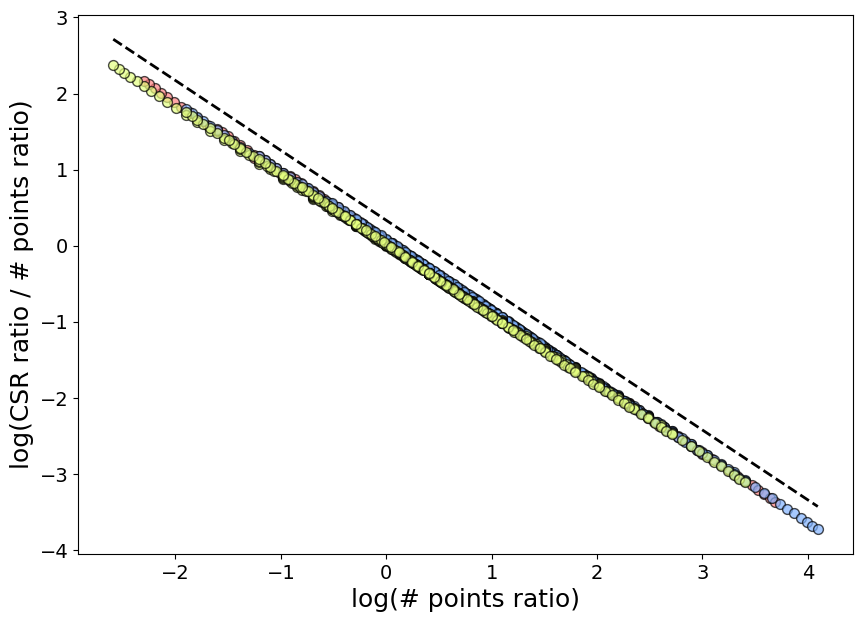

In [ ]:
# log(CSR_ratio/tpoints_ratio) vs log(tpoints_ratio)

plt.figure(figsize=(10, 7))

plt.scatter(np.log(tpoints_ratio01), np.log(CSR_ratio01/tpoints_ratio01),
            facecolors=hsv_to_rgb((0, 0.5, 1)), edgecolors="k", s=50, alpha=0.7)

plt.scatter(np.log(tpoints_ratio02), np.log(CSR_ratio02/tpoints_ratio02),
            facecolors=hsv_to_rgb((0.6, 0.5, 1)), edgecolors="k", s=50, alpha=0.7)

plt.scatter(np.log(tpoints_ratio12), np.log(CSR_ratio12/tpoints_ratio12),
            facecolors=hsv_to_rgb((0.2, 0.5, 1)), edgecolors="k", s=50, alpha=0.7)

reg = lm.LinearRegression()
tpoints_ratio = np.concatenate(
    (tpoints_ratio01, tpoints_ratio02, tpoints_ratio12))
CSR_ratio = np.concatenate((CSR_ratio01, CSR_ratio02, CSR_ratio12))
reg.fit(np.log(tpoints_ratio).reshape((-1, 1)),
        np.log(CSR_ratio/tpoints_ratio))
x_ext = np.array([np.min(np.log(tpoints_ratio)),
                 np.max(np.log(tpoints_ratio))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1, 1)))+0.3, c="k", lw=2, ls="--")

print("R2 score =", reg.score(np.log(tpoints_ratio).reshape(
    (-1, 1)), np.log(CSR_ratio/tpoints_ratio)))

plt.xlabel("log(# points ratio)", fontsize=18)
plt.ylabel("log(CSR ratio / # points ratio)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


---

In [14]:
def lr_fim(x, y, lr, Sig):
    S = np.zeros((np.prod(x.shape), x.shape[1]*(x.shape[1]+1)))
    for i in range(x.shape[1]):
        S[i::x.shape[1], i] = 1.
        S[i::x.shape[1], (i+1)*x.shape[1]:(i+2)*x.shape[1]] = x

    F = S.T@np.diag(list(1/Sig)*x.shape[0])@S

    return F


In [15]:
def taros(x, y, lr):
    rms = np.zeros_like(lr.coef_)
    for i in range(rms.shape[0]):
        rms[i] = np.sqrt(((lr.coef_[i]*x/y[:,[i]])**2).sum(0))/len(x)

    return rms


In [16]:
def BIC(x, y, lr, Sig):
    n_p = len(lr.intercept_)
    n_p *= n_p+1

    return n_p*np.log(len(x)) + ((y-lr.predict(x))**2/Sig).sum() + len(y)*n_p*np.log(2*np.pi) + np.log(Sig.prod())*len(y)


def AIC(x, y, lr, Sig):
    n_p = len(lr.intercept_)
    n_p *= n_p+1

    return 2*n_p + ((y-lr.predict(x))**2/Sig).sum() + len(y)*n_p*np.log(2*np.pi) + np.log(Sig.prod())*len(y)


def AICc(x, y, lr, Sig):
    n_p = len(lr.intercept_)
    n_p *= n_p+1

    return 2*n_p*(n_p+1)/(len(y)-n_p-1) + ((y-lr.predict(x))**2/Sig).sum() + len(y)*n_p*np.log(2*np.pi) + np.log(Sig.prod())*len(y)


def CAICF(x, y, lr, Sig):
    n_p = len(lr.intercept_)
    n_p *= n_p+1

    return n_p*(np.log(len(x))+2) + ((y-lr.predict(x))**2/Sig).sum() + len(y)*n_p*np.log(2*np.pi) + np.log(Sig.prod())*len(y) - np.log(np.linalg.det(lr_fim(x, y, lr, Sig)))

In [ ]:
a = pd.read_csv(datafiles[2][2], index_col=0)
add_log_time_diff(a)

# reg = lm.RidgeCV(alphas=10.**np.arange(-5, 3))
reg = lm.RidgeCV()
y = a.dropna()[[i for i in a.columns if i[:2] == "sp"]].values
dlogydt = a.dropna()[[i for i in a.columns if i[:6] == "dlogsp"]].values
reg.fit(y, dlogydt)

Sig = (dlogydt-reg.predict(y)).var(0)

F = lr_fim(y, dlogydt, reg, Sig)
cov = np.linalg.inv(F)

print(BIC(y, dlogydt, reg, Sig), AIC(y, dlogydt, reg, Sig),
      AICc(y, dlogydt, reg, Sig), CAICF(y, dlogydt, reg, Sig), np.log(np.linalg.det(taros(y, dlogydt, reg))))

105731.83395948613 105248.17169741236 105078.1103477191 105622.54711162487 2.6934833356232866


In [ ]:
n_sp = 10

In [ ]:
true_params = get_meta(open(metadatafiles[2][2]).read().split("\n"))[
    "parameters"]

true_r = true_params[:n_sp]
true_A = true_params[n_sp:].reshape((n_sp, n_sp))

print((np.sign(true_A) == np.sign(reg.coef_)).mean(), np.sqrt(((true_A-reg.coef_).flatten()**2).mean()),
      np.sqrt(((true_A-reg.coef_).flatten()**2/np.diag(cov)[n_sp:]).mean()), reg.score(y[:], dlogydt[:]), np.linalg.det(F))

0.85 0.7025748751722237 1.910282393996368 0.4012306658973982 1.0173279805102195e+143


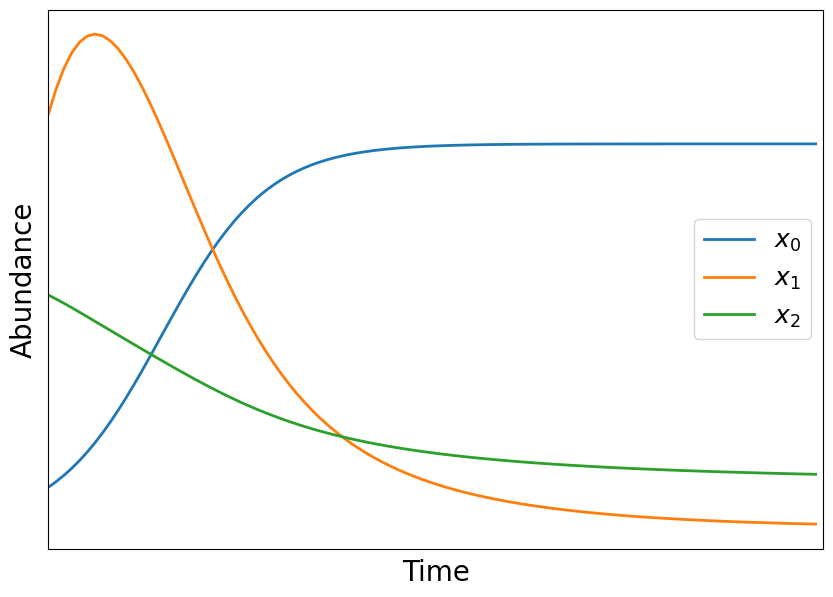

In [ ]:
np.random.seed(7)
x0 = np.random.uniform(0, 1, 3)
r = np.random.uniform(0, 1, 3)
A = np.random.normal(size=(3,3))
A = A-A*np.eye(3)-np.eye(3)
p = np.concatenate((r, A.flatten()))
plt.figure(figsize=(10,7))
abund = euler_maruyama(glv, 0., x0, p, 0., 0.001, np.linspace(0, 20, 100), 0)
for i in range(3):
    plt.plot(abund[:,i], lw=2, label=f"$x_{i}$")
plt.xlim(0, 100)
plt.xticks([])
plt.yticks([])
plt.xlabel("Time", fontsize=20)
plt.ylabel("Abundance", fontsize=20)
plt.legend(loc="center right", fontsize=18)
plt.savefig("glv_traj.png", dpi=300, bbox_inches="tight")

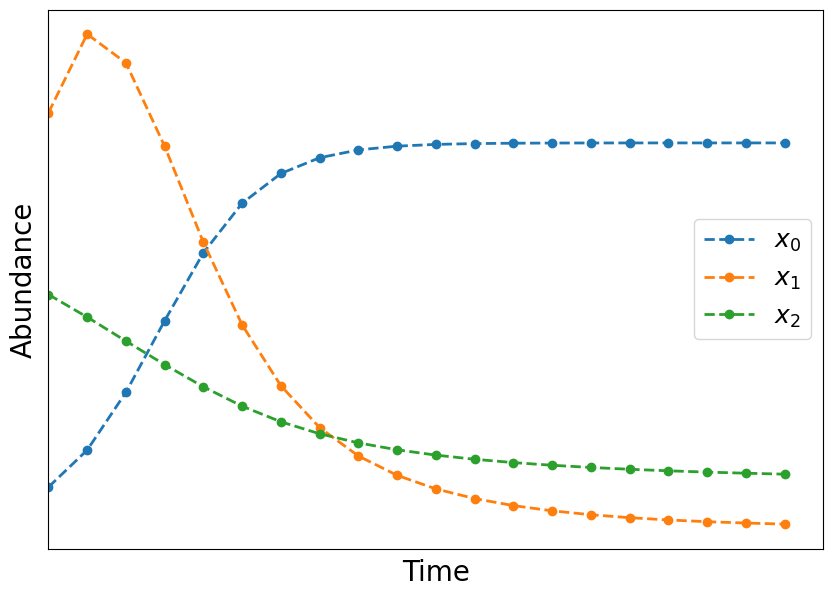

In [ ]:
np.random.seed(7)
x0 = np.random.uniform(0, 1, 3)
r = np.random.uniform(0, 1, 3)
A = np.random.normal(size=(3,3))
A = A-A*np.eye(3)-np.eye(3)
p = np.concatenate((r, A.flatten()))
plt.figure(figsize=(10,7))
abund = euler_maruyama(glv, 0., x0, p, 0., 0.001, np.linspace(0, 20, 20), 0)
for i in range(3):
    plt.plot(abund[:,i], "--o", lw=2, label=f"$x_{i}$")
plt.xlim(0, 20)
plt.xticks([])
plt.yticks([])
plt.xlabel("Time", fontsize=20)
plt.ylabel("Abundance", fontsize=20)
plt.legend(loc="center right", fontsize=18)
plt.savefig("glv_traj_subsample.png", dpi=300, bbox_inches="tight")

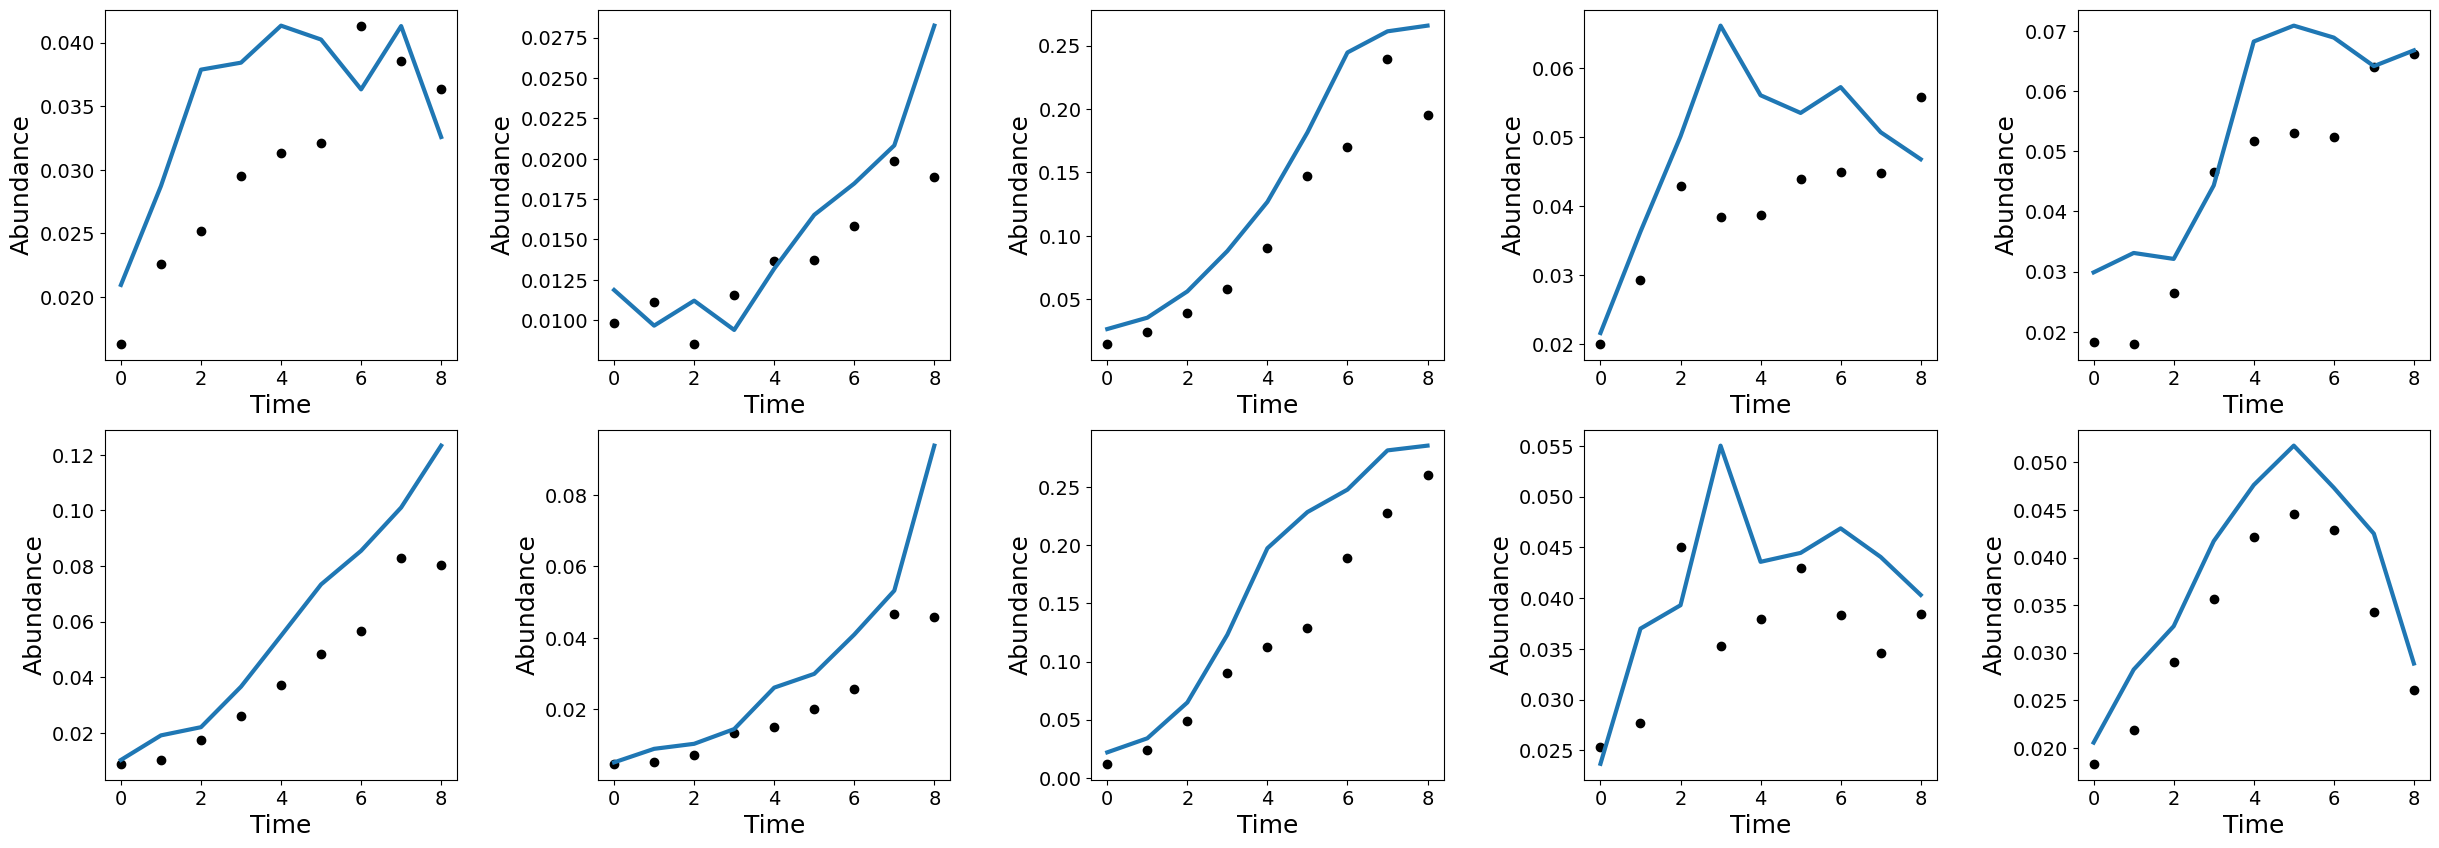

In [ ]:
reg_ = lm.RidgeCV(alphas=10.**np.arange(-10,10))
# reg_ = lm.RidgeCV()
reg_.fit(y[:60], dlogydt[:60])
plt.subplots(2, 5, figsize=(30,10))
plt.subplots_adjust(wspace=0.4)
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.plot(y[1:10,i], "o", c="k")
    plt.plot((y[:9]+3*y[:9]*reg_.predict(y[:9]))[:,i], lw=3)
    plt.xlabel("Time", fontsize=18)
    plt.ylabel("Abundance", fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    # plt.ylim(0, 0.4)
# plt.savefig("simple_glv_fit.png", dpi=300, bbox_inches="tight")

In [ ]:
reg_.alpha_

0.01

In [ ]:
(np.sign(true_A)==np.sign(reg_.coef_)).mean()

0.74

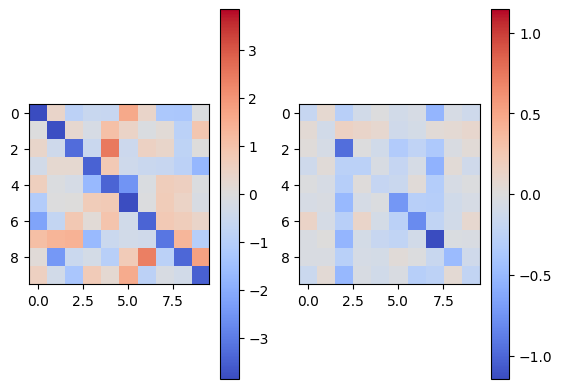

In [ ]:
plt.subplots(1, 2)
plt.subplot(1, 2, 1)
plt.imshow(true_A, cmap="coolwarm", vmin=-np.abs(true_A).max(), vmax=np.abs(true_A).max())
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(reg_.coef_, cmap="coolwarm", vmin=-np.abs(reg_.coef_).max(), vmax=np.abs(reg_.coef_).max())
plt.colorbar()
plt.show()

Text(0.5, 1.0, 'Inferred interaction sign')

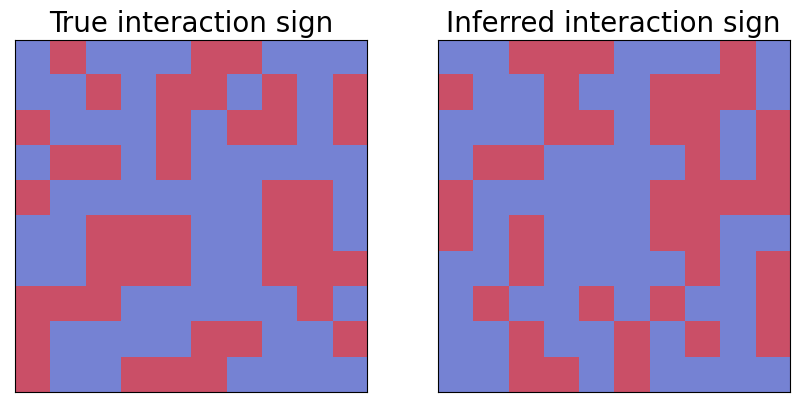

In [ ]:
plt.subplots(1, 2, figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(np.sign(true_A), cmap="coolwarm", alpha=0.7)
plt.xticks([])
plt.yticks([])
plt.grid(c="k")
plt.title("True interaction sign", fontsize=20)
plt.subplot(1, 2, 2)
plt.imshow(np.sign(reg_.coef_), cmap="coolwarm", alpha=0.7)
plt.xticks([])
plt.yticks([])
plt.title("Inferred interaction sign", fontsize=20)

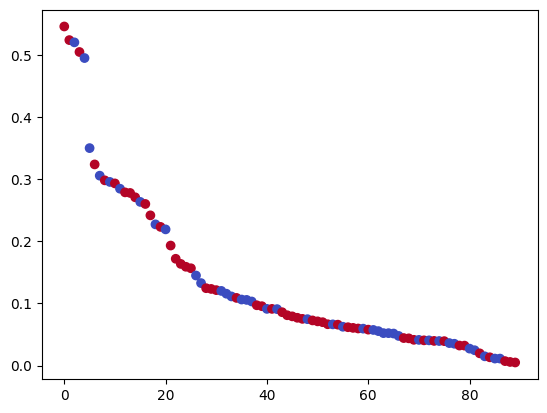

In [ ]:
plt.scatter(np.arange(90), np.abs(reg__coef_no_diag)[np.argsort(np.abs(reg__coef_no_diag))][::-1], c=(np.sign(true_A_no_diag)==np.sign(reg__coef_no_diag))[np.argsort(np.abs(reg__coef_no_diag))][::-1], cmap="coolwarm")

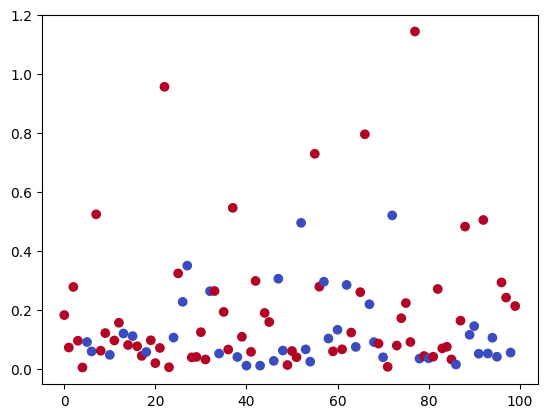

In [ ]:
plt.scatter(np.arange(100), np.abs(reg_.coef_), c=(np.sign(true_A)==np.sign(reg_.coef_)).flatten(), cmap="coolwarm")

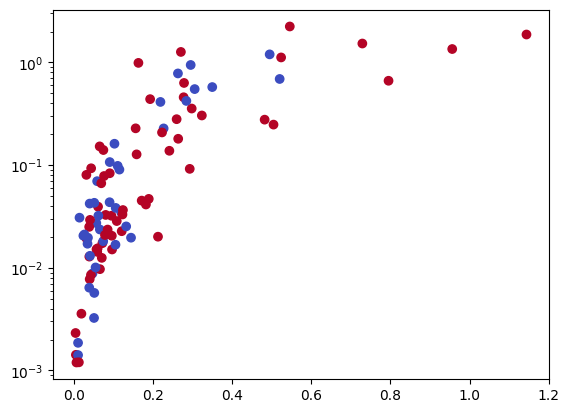

In [ ]:
plt.scatter(np.abs(reg_.coef_), taros(y, dlogydt, reg_), c=(np.sign(true_A)==np.sign(reg_.coef_)).flatten(), cmap="coolwarm")
plt.yscale("log")

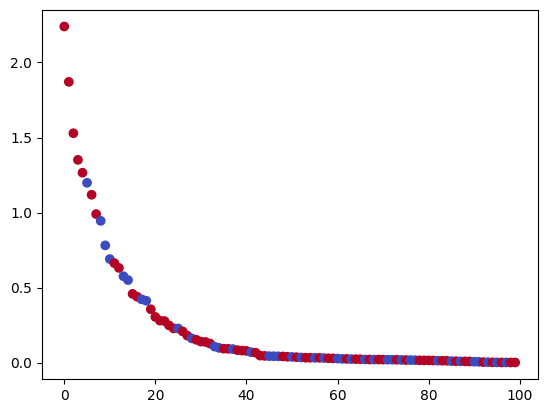

In [ ]:
plt.scatter(np.arange(100), taros(y, dlogydt, reg_).flatten()[np.argsort(taros(y, dlogydt, reg_).flatten())][::-1], c=(np.sign(true_A)==np.sign(reg_.coef_)).flatten()[np.argsort(taros(y, dlogydt, reg_).flatten())][::-1], cmap="coolwarm")
# plt.yscale("log")

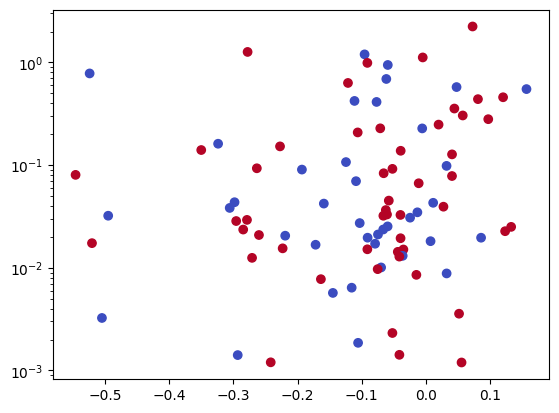

In [ ]:
plt.scatter(reg__coef_no_diag, np.concatenate([taros(y, dlogydt, reg_)[i, [j for j in range(n_sp) if j!=i]] for i in range(n_sp)])[np.argsort(np.concatenate([taros(y, dlogydt, reg_)[i, [j for j in range(n_sp) if j!=i]] for i in range(n_sp)]))][::-1], c=(np.sign(true_A_no_diag)==np.sign(reg__coef_no_diag))[np.argsort(np.concatenate([taros(y, dlogydt, reg_)[i, [j for j in range(n_sp) if j!=i]] for i in range(n_sp)]))][::-1], cmap="coolwarm")
plt.yscale("log")

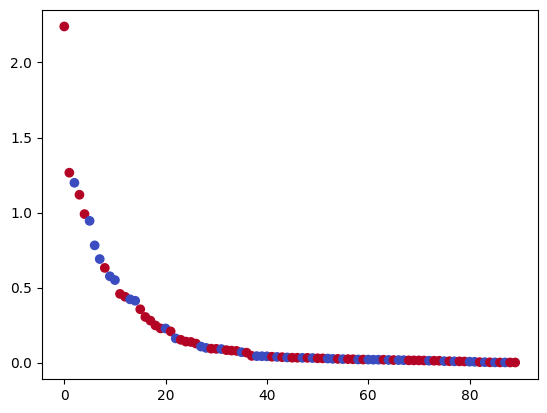

In [ ]:
plt.scatter(np.arange(90), np.concatenate([taros(y, dlogydt, reg_)[i, [j for j in range(n_sp) if j!=i]] for i in range(n_sp)])[np.argsort(np.concatenate([taros(y, dlogydt, reg_)[i, [j for j in range(n_sp) if j!=i]] for i in range(n_sp)]))][::-1], c=(np.sign(true_A_no_diag)==np.sign(reg__coef_no_diag))[np.argsort(np.concatenate([taros(y, dlogydt, reg_)[i, [j for j in range(n_sp) if j!=i]] for i in range(n_sp)]))][::-1], cmap="coolwarm")
# plt.yscale("log")

In [ ]:
rmsd = []
csr = []
# for dset in a.dataset.unique():
for k in range(10, 15):
    combs = list(combinations(a["dataset"].unique(), k))
    np.random.shuffle(combs)
    combs = combs[:100]
    for comb in combs:
        a_train = pd.concat([a[a["dataset"]==i] for i in comb])
        a_test = pd.concat([a[a["dataset"]==i] for i in a["dataset"].unique() if i not in comb])
        y_train = a_train.dropna()[[i for i in a_train.columns if i[:2] == "sp"]].values
        y_test = a_test.dropna()[[i for i in a_test.columns if i[:2] == "sp"]].values
        dlogydt_train = a_train.dropna()[[i for i in a_train.columns if i[:6] == "dlogsp"]].values
        dlogydt_test = a_test.dropna()[[i for i in a_test.columns if i[:6] == "dlogsp"]].values
        
        reg = lm.LinearRegression()
        reg.fit(y_train, dlogydt_train)
        
        csr.append((np.sign(true_A)==np.sign(reg.coef_)).mean())
        rmsd.append(((dlogydt_test-reg.predict(y_test))**2).sum()**0.5)

csr = np.array(csr)
rmsd = np.array(rmsd)

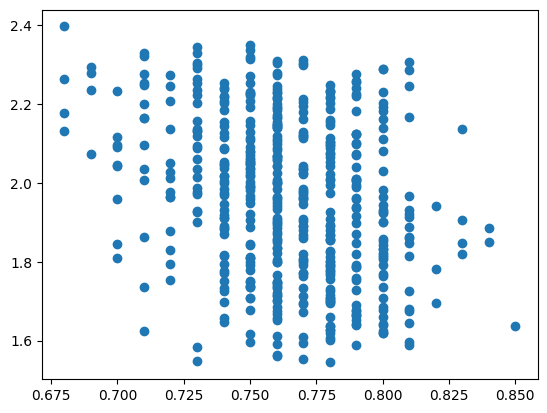

In [ ]:
plt.scatter(csr, rmsd)
reg_ = lm.LinearRegression()
# plt.yscale("log")
# plt.xscale("log")

In [ ]:
rmsd_mean = []
for i in np.unique(csr):
    rmsd_mean.append(rmsd[np.where(csr==i)].mean())

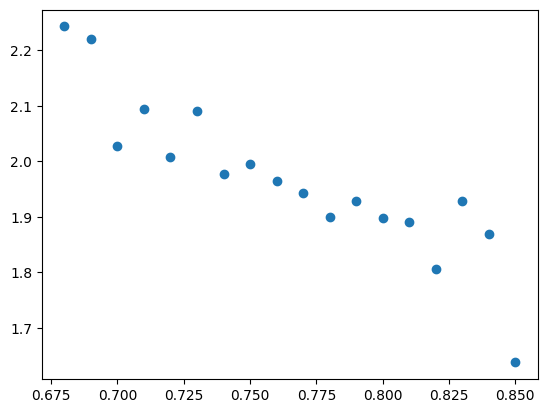

In [ ]:
plt.plot(np.unique(csr), rmsd_mean, "o")

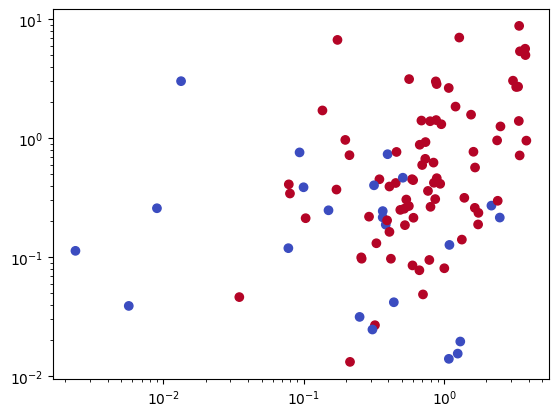

In [ ]:
plt.scatter(np.abs(true_A).flatten(), taros(y, dlogydt, reg).flatten(), c=(np.sign(true_A)==np.sign(reg.coef_)).flatten(), cmap="coolwarm")
# plt.colorbar()
plt.xscale("log")
plt.yscale("log")

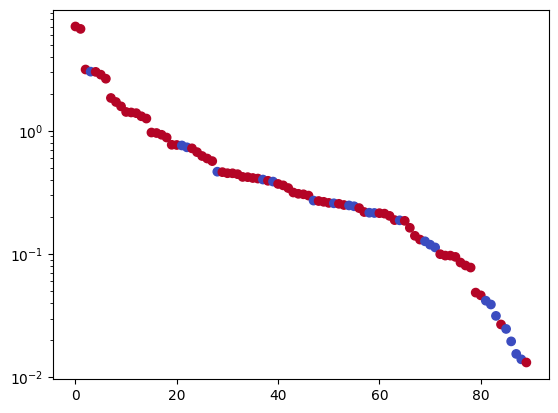

In [ ]:
reg_coef_no_diag = np.concatenate([reg.coef_[i,[j for j in range(n_sp) if j!=i]] for i in range(n_sp)])
true_A_no_diag = np.concatenate([true_A[i,[j for j in range(n_sp) if j!=i]] for i in range(n_sp)])

plt.scatter(np.arange(90), np.concatenate([taros(y, dlogydt, reg)[i, [j for j in range(n_sp) if j!=i]] for i in range(n_sp)])[np.argsort(np.concatenate([taros(y, dlogydt, reg)[i, [j for j in range(n_sp) if j!=i]] for i in range(n_sp)]))][::-1], c=(np.sign(true_A_no_diag)==np.sign(reg_coef_no_diag))[np.argsort(np.concatenate([taros(y, dlogydt, reg)[i, [j for j in range(n_sp) if j!=i]] for i in range(n_sp)]))][::-1], cmap="coolwarm")
plt.yscale("log")

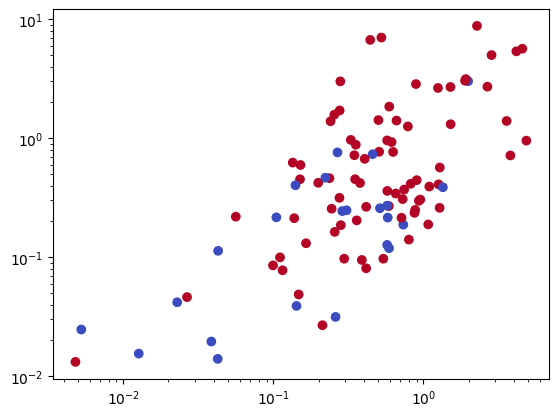

In [ ]:
plt.scatter(np.abs(reg.coef_).flatten(), taros(y, dlogydt, reg).flatten(), c=(np.sign(true_A)==np.sign(reg.coef_)).flatten(), cmap="coolwarm")
# plt.colorbar()
plt.xscale("log")
plt.yscale("log")

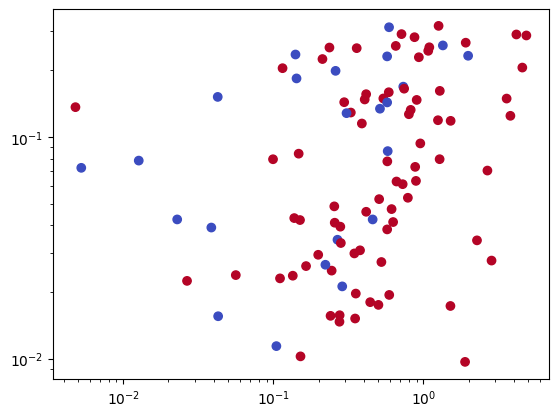

In [ ]:
plt.scatter(np.abs(reg.coef_).flatten(), np.diag(cov)[n_sp:], c=(np.sign(true_A)==np.sign(reg.coef_)).flatten(), cmap="coolwarm")
plt.xscale("log")
plt.yscale("log")

In [ ]:
cv_taros = []
cv_var = []
cv_score = []
cv_BIC = []
cv_AIC = []
cv_AICc = []
cv_FIM = []

# for dataset in a["dataset"].unique():
y = a[a["dataset"] < 10].dropna(
)[[i for i in a.columns if i[:2] == "sp"]].values
dlogydt = a[a["dataset"] < 10].dropna(
)[[i for i in a.columns if i[:6] == "dlogsp"]].values

reg = lm.LinearRegression()
reg.fit(y, dlogydt)
Sig = (dlogydt-reg.predict(y)).var(0)

y_cv = a[a["dataset"] > 10].dropna(
)[[i for i in a.columns if i[:2] == "sp"]].values
dlogydt_cv = a[a["dataset"] > 10].dropna(
)[[i for i in a.columns if i[:6] == "dlogsp"]].values

cv_taros.append(np.log((taros(y_cv, dlogydt_cv, reg)).sum()))
# cv_taros.append(np.log(np.linalg.det(taros(y_cv, dlogydt_cv, reg))))
cv_var.append(((dlogydt_cv-reg.predict(y_cv))**2).mean())
cv_score.append(reg.score(y_cv, dlogydt_cv))
cv_BIC.append(BIC(y_cv, dlogydt_cv, reg, Sig))
cv_AIC.append(AIC(y_cv, dlogydt_cv, reg, Sig))
cv_AICc.append(AICc(y_cv, dlogydt_cv, reg, Sig))
cv_FIM.append(np.linalg.det(lr_fim(y_cv, dlogydt_cv, reg, Sig)))

cv_taros = np.array(cv_taros)
cv_var = np.array(cv_var)
cv_score = np.array(cv_score)
cv_BIC = np.array(cv_BIC)
cv_AIC = np.array(cv_AIC)
cv_AICc = np.array(cv_AICc)
cv_FIM = np.array(cv_FIM)

print(cv_taros.mean(), cv_taros.std())
print(cv_var.mean(), cv_var.std())
print(cv_score.mean(), cv_score.std())
print(cv_BIC.mean(), cv_BIC.std())
print(cv_AIC.mean(), cv_AIC.std())
print(cv_AICc.mean(), cv_AICc.std())
print(cv_FIM.mean(), cv_FIM.std())

4.866505164708734 0.0
0.004747361438213974 0.0
0.6783660304721053 0.0
14798.911655140659 0.0
14523.93259140433 0.0
13141.075448547188 0.0
8.124778961670547e+132 0.0


In [20]:
a2 = pd.read_csv(datafiles[2][2], index_col=0)
add_log_time_diff(a2)

reg2 = lm.RidgeCV()#alphas=10.**np.arange(-5,3))
y2 = a2.dropna()[[i for i in a2.columns if i[:2] == "sp"]].values
dlogydt2 = a2.dropna()[[i for i in a2.columns if i[:6] == "dlogsp"]].values
reg2.fit(y2, dlogydt2)

# Sig2 = (dlogydt2-reg2.predict(y2)).var(0)

# F2 = lr_fim(y2, dlogydt2, reg2, Sig2)
# cov2 = np.linalg.inv(F2)

# print(BIC(y2, dlogydt2, reg2, Sig2), AIC(y2, dlogydt2, reg2, Sig2),
#       AICc(y2, dlogydt2, reg2, Sig2), CAICF(y2, dlogydt2, reg2, Sig2), np.log(np.linalg.det(taros(y2, dlogydt2, reg2))))

RidgeCV()

In [21]:
n_sp = 10

In [22]:
true_params = get_meta(open(metadatafiles[2][2]).read().split("\n"))[
    "parameters"]

true_r = true_params[:n_sp]
true_A = true_params[n_sp:].reshape((n_sp, n_sp))

print((np.sign(true_A) == np.sign(reg2.coef_)).mean(), np.sqrt(((true_A-reg2.coef_).flatten()**2).mean()),
      np.sqrt(((true_A-reg2.coef_).flatten()**2/np.diag(cov2)[n_sp:]).mean()), reg2.score(y2[:], dlogydt2[:]), np.linalg.det(F2))

NameError: name 'cov2' is not defined

In [23]:
reg2_coef_no_diag = np.concatenate([reg2.coef_[i,[j for j in range(n_sp) if j!=i]] for i in range(n_sp)])
true_A_no_diag = np.concatenate([true_A[i,[j for j in range(n_sp) if j!=i]] for i in range(n_sp)])

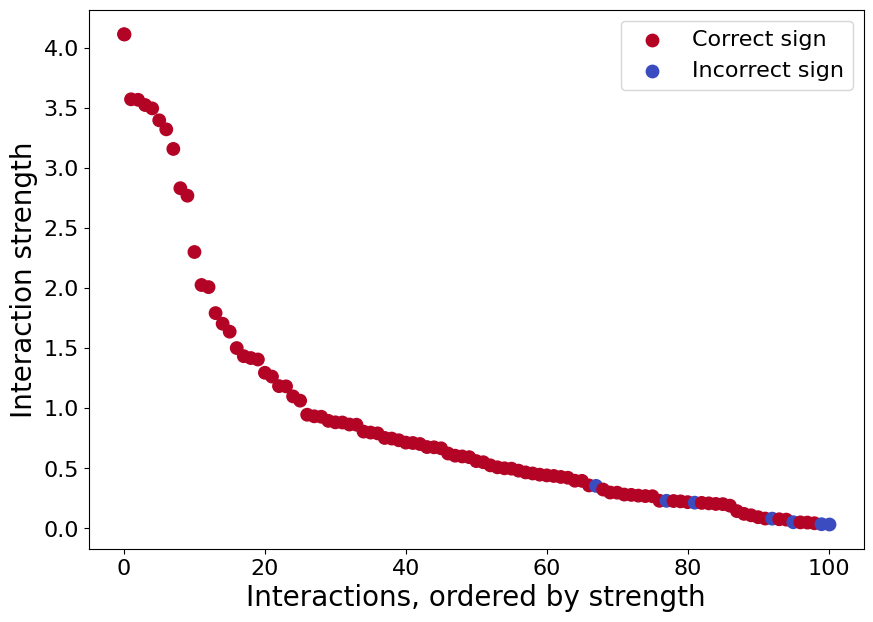

In [24]:
plt.figure(figsize=(10,7))
plt.scatter(np.arange(100), np.abs(reg2.coef_.flatten())[np.argsort(np.abs(reg2.coef_.flatten()))][::-1], c=(np.sign(true_A)==np.sign(reg2.coef_)).flatten()[np.argsort(np.abs(reg2.coef_.flatten()))][::-1], cmap="coolwarm", s=80, vmin=0, vmax=1)
plt.scatter(0, np.abs(reg2.coef_.flatten())[np.argsort(np.abs(reg2.coef_.flatten()))][::-1][0], c=1, cmap="coolwarm", s=80, vmin=-0, vmax=1, label="Correct sign")
plt.scatter(100, np.abs(reg2.coef_.flatten())[np.argsort(np.abs(reg2.coef_.flatten()))][::-1][-1], c=0, cmap="coolwarm", s=80, vmin=-0, vmax=1, label="Incorrect sign")
plt.legend(fontsize=16)
plt.xlabel("Interactions, ordered by strength", fontsize=20)
plt.ylabel("Interaction strength", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.yscale("log")
# plt.show()
plt.savefig("int_strength.png", dpi=300, bbox_inches="tight")

In [ ]:
np.where((np.sign(true_A)==np.sign(reg2.coef_)).flatten())[0]

array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 14, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 64, 65, 66, 67, 68, 70, 71, 72, 73, 75, 77, 78, 79, 82, 84,
       85, 86, 87, 88, 92, 93, 95, 96, 97, 98, 99])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


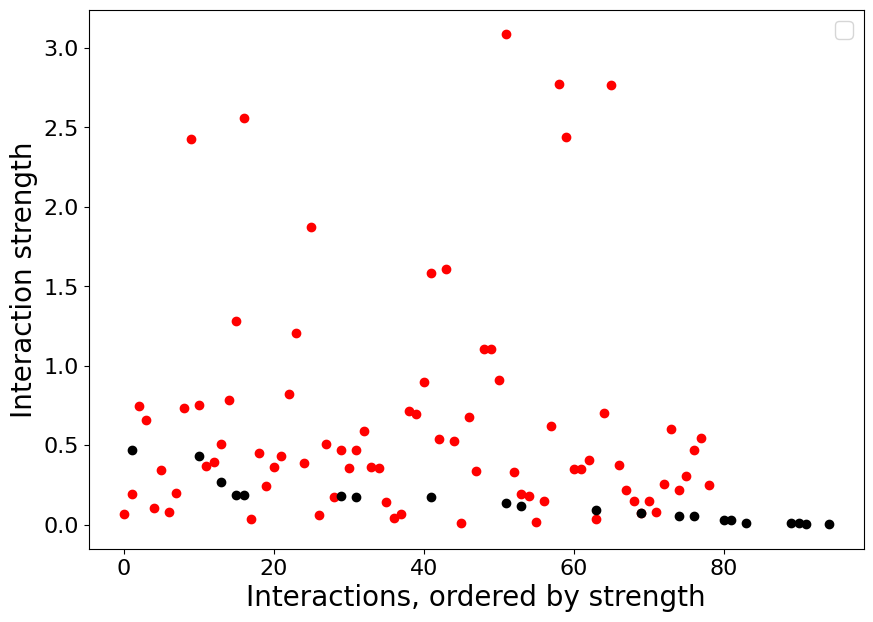

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(np.where((np.sign(true_A)==np.sign(reg2.coef_)).flatten())[0], np.abs(reg2.coef_[(np.sign(true_A)==np.sign(reg2.coef_))].flatten())[np.argsort(np.abs(reg2.coef_[(np.sign(true_A)==np.sign(reg2.coef_))].flatten()))][::-1], "o", c="r")
plt.plot(np.where((np.sign(true_A)!=np.sign(reg2.coef_)).flatten())[0], np.abs(reg2.coef_[(np.sign(true_A)!=np.sign(reg2.coef_))].flatten())[np.argsort(np.abs(reg2.coef_[(np.sign(true_A)!=np.sign(reg2.coef_))].flatten()))][::-1], "o", c="k")
# plt.scatter(0, np.abs(reg2.coef_.flatten())[np.argsort(np.abs(reg2.coef_.flatten()))][::-1][0], c=1, cmap="coolwarm", s=80, vmin=-0, vmax=1, label="Correct sign")
# plt.scatter(100, np.abs(reg2.coef_.flatten())[np.argsort(np.abs(reg2.coef_.flatten()))][::-1][-1], c=0, cmap="coolwarm", s=80, vmin=-0, vmax=1, label="Incorrect sign")
plt.legend(fontsize=16)
plt.xlabel("Interactions, ordered by strength", fontsize=20)
plt.ylabel("Interaction strength", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.yscale("log")
# plt.show()
plt.savefig("int_strength.png", dpi=300, bbox_inches="tight")

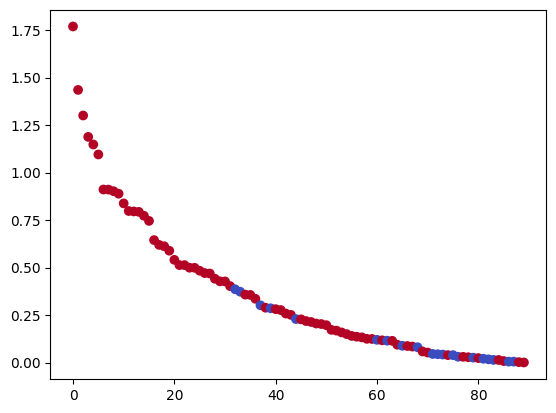

In [ ]:
plt.scatter(np.arange(90), np.abs(reg2_coef_no_diag)[np.argsort(np.abs(reg2_coef_no_diag))][::-1], c=(np.sign(true_A_no_diag)==np.sign(reg2_coef_no_diag))[np.argsort(np.abs(reg2_coef_no_diag))][::-1], cmap="coolwarm")

In [ ]:
datafiles[2]

['../experiment_outputs/growth_scale_0.001_10_sp_env_noise0.1/10_sp/param_seed0/meas_noise0.1/t_samp1.0/dataset10_sp0_env_noise0.1.csv',
 '../experiment_outputs/growth_scale_0.001_10_sp_env_noise0.1/10_sp/param_seed1/meas_noise0.1/t_samp1.0/dataset10_sp1_env_noise0.1.csv',
 '../experiment_outputs/growth_scale_0.001_10_sp_env_noise0.1/10_sp/param_seed2/meas_noise0.1/t_samp1.0/dataset10_sp2_env_noise0.1.csv',
 '../experiment_outputs/growth_scale_0.001_10_sp_env_noise0.1/10_sp/param_seed3/meas_noise0.1/t_samp1.0/dataset10_sp3_env_noise0.1.csv',
 '../experiment_outputs/growth_scale_0.001_10_sp_env_noise0.1/10_sp/param_seed4/meas_noise0.1/t_samp1.0/dataset10_sp4_env_noise0.1.csv']

In [ ]:
np.percentile(l, 25, axis=1)

array([ 4.,  5.,  9., 13., 16., 19., 20., 18., 21., 21., 23., 24., 25.,
       20., 23., 29., 30., 31., 29., 34.])

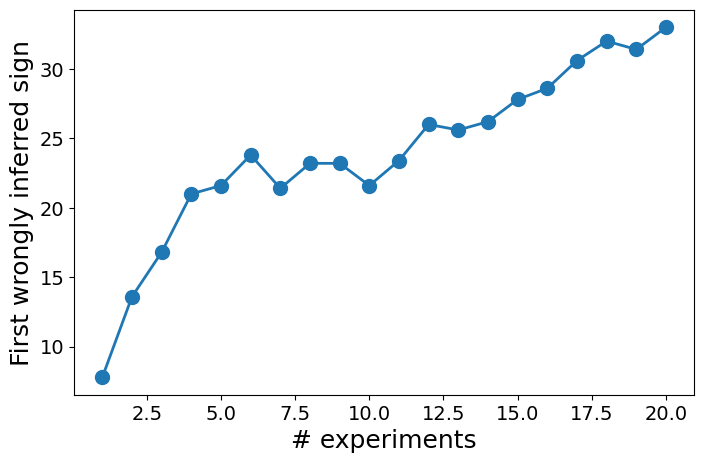

In [ ]:
l = np.zeros((20, 5))
for j in range(5):
    a2 = pd.read_csv(datafiles[2][j], index_col=0)
    add_log_time_diff(a2)
    y2 = a2.dropna()[[i for i in a2.columns if i[:2] == "sp"]].values
    dlogydt2 = a2.dropna()[[i for i in a2.columns if i[:6] == "dlogsp"]].values

    true_params = get_meta(open(metadatafiles[2][j]).read().split("\n"))[
    "parameters"]
    true_A = true_params[n_sp:].reshape((n_sp, n_sp))

    for i in range(20):
        reg_ = lm.RidgeCV()
        reg_.fit(y2[:30*(i+1)], dlogydt2[:30*(i+1)])
        l[i,j] = np.where((np.sign(reg_.coef_)==np.sign(true_A)).flatten()[np.argsort(np.abs(reg_.coef_.flatten()))][::-1]==0.)[0][0]

plt.figure(figsize=(8,5))
plt.plot(np.arange(1, 21), l.mean(1)+1, "-o", ms=10, lw=2)
plt.ylabel("First wrongly inferred sign", fontsize=18)
plt.xlabel("# experiments", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.yscale("log")
# plt.show()
plt.savefig("wrong_sign_rank_vs_#exp.png", dpi=300, bbox_inches="tight")

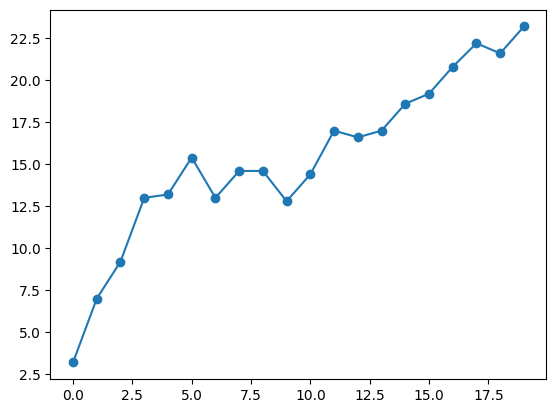

In [ ]:
l = np.zeros((20, 5))
for j in range(5):
    a2 = pd.read_csv(datafiles[2][j], index_col=0)
    add_log_time_diff(a2)
    y2 = a2.dropna()[[i for i in a2.columns if i[:2] == "sp"]].values
    dlogydt2 = a2.dropna()[[i for i in a2.columns if i[:6] == "dlogsp"]].values

    true_params = get_meta(open(meta    datafiles[2][j]).read().split("\n"))[
    "parameters"]
    true_A = true_params[n_sp:].reshape((n_sp, n_sp))

    for i in range(20):
        reg_ = lm.RidgeCV()
        reg_.fit(y2[:30*(i+1)], dlogydt2[:30*(i+1)])

        reg2_coef_no_diag = np.concatenate([reg_.coef_[i,[j for j in range(n_sp) if j!=i]] for i in range(n_sp)])
        true_A_no_diag = np.concatenate([true_A[i,[j for j in range(n_sp) if j!=i]] for i in range(n_sp)])

        l[i,j] = np.where((np.sign(reg2_coef_no_diag)==np.sign(true_A_no_diag)).flatten()[np.argsort(np.abs(reg2_coef_no_diag))][::-1]==0.)[0][0]
plt.plot(l.mean(1), "-o")

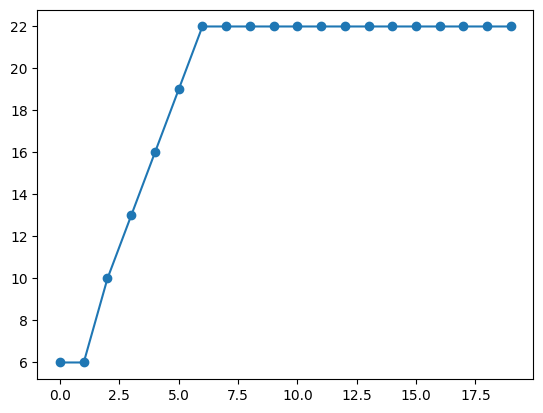

In [ ]:
l = []
for i in range(1, 21):
    reg_ = lm.RidgeCV()
    reg_.fit(y[:30*i], dlogydt[:30*i])
    l.append(np.where((np.sign(reg_.coef_)==np.sign(true_A)).flatten()[np.argsort(np.abs(reg_.coef_.flatten()))][::-1]==0.)[0][0])
plt.plot(l, "-o")

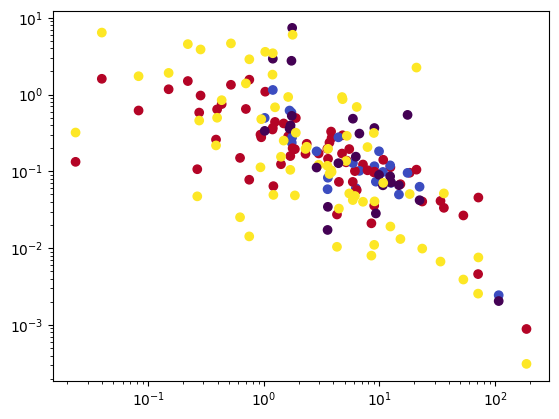

In [ ]:
plt.scatter(np.abs((reg2_coef_no_diag-true_A_no_diag)/reg2_coef_no_diag), np.abs(reg2_coef_no_diag), c=(np.sign(true_A_no_diag)==np.sign(reg2_coef_no_diag)), cmap="coolwarm")
plt.scatter(np.abs(reg2_coef_no_diag-true_A_no_diag)/np.abs(reg2_coef_no_diag), np.concatenate([taros(y, dlogydt, reg2)[i, [j for j in range(n_sp) if j!=i]] for i in range(n_sp)]), c=(np.sign(true_A_no_diag)==np.sign(reg2_coef_no_diag)))
plt.xscale("log")
plt.yscale("log")

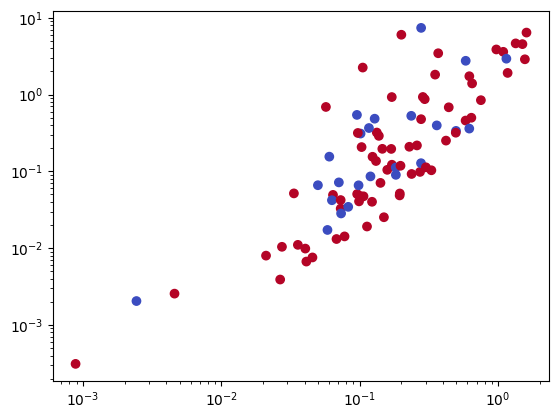

In [ ]:
plt.scatter(np.abs(reg2_coef_no_diag), np.concatenate([taros(y, dlogydt, reg2)[i, [j for j in range(n_sp) if j!=i]] for i in range(n_sp)]), c=(np.sign(true_A_no_diag)==np.sign(reg2_coef_no_diag)), cmap="coolwarm")
plt.xscale("log")
plt.yscale("log")

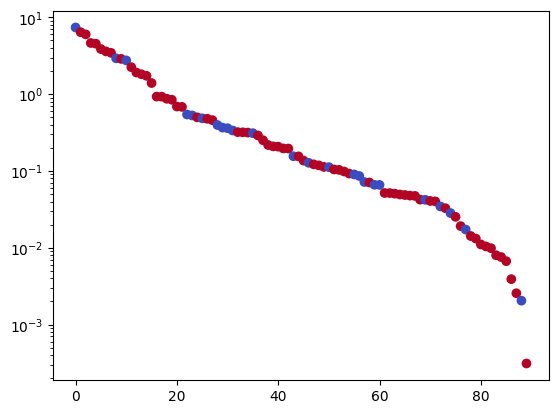

In [ ]:
plt.scatter(np.arange(90), np.concatenate([taros(y, dlogydt, reg2)[i, [j for j in range(n_sp) if j!=i]] for i in range(n_sp)])[np.argsort(np.concatenate([taros(y, dlogydt, reg2)[i, [j for j in range(n_sp) if j!=i]] for i in range(n_sp)]))][::-1], c=(np.sign(true_A_no_diag)==np.sign(reg2_coef_no_diag))[np.argsort(np.concatenate([taros(y, dlogydt, reg2)[i, [j for j in range(n_sp) if j!=i]] for i in range(n_sp)]))][::-1], cmap="coolwarm")
plt.yscale("log")

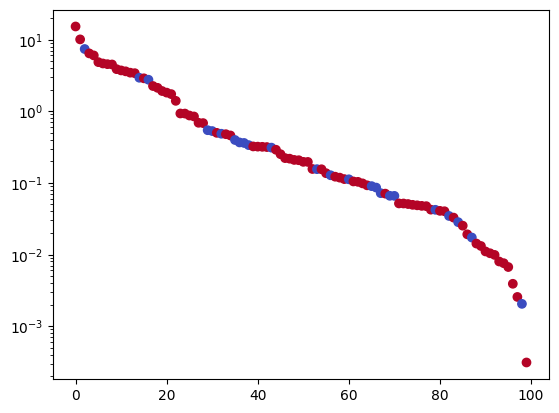

In [ ]:
plt.scatter(np.arange(100), taros(y, dlogydt, reg2).flatten()[np.argsort(taros(y, dlogydt, reg2).flatten())][::-1], c=(np.sign(true_A)==np.sign(reg2.coef_)).flatten()[np.argsort(taros(y, dlogydt, reg2).flatten())][::-1], cmap="coolwarm")
plt.yscale("log")

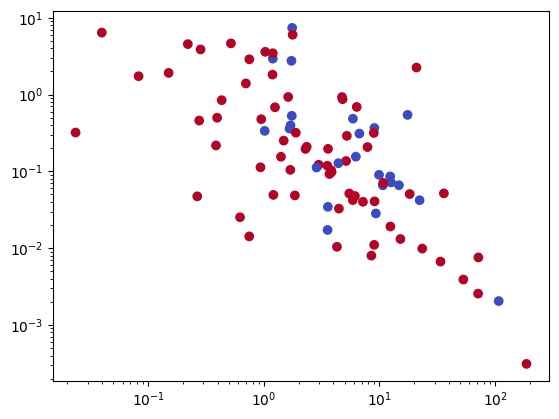

In [ ]:
plt.scatter(np.abs(reg2_coef_no_diag-true_A_no_diag)/np.abs(reg2_coef_no_diag), np.concatenate([taros(y, dlogydt, reg2)[i, [j for j in range(n_sp) if j!=i]] for i in range(n_sp)]), c=(np.sign(true_A_no_diag)==np.sign(reg2_coef_no_diag)), cmap="coolwarm")
plt.xscale("log")
plt.yscale("log")

NameError: name 'st' is not defined

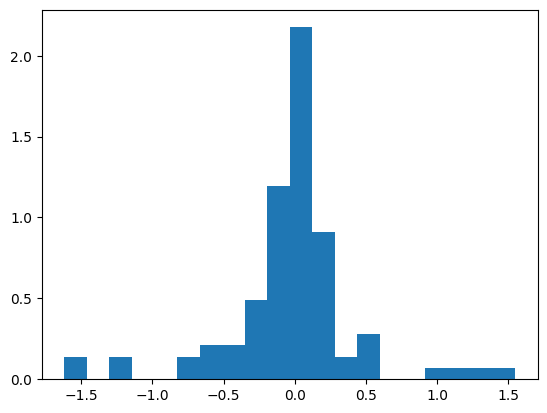

In [ ]:
plt.hist((reg2_coef_no_diag-reg2_coef_no_diag.mean()/reg2_coef_no_diag.std()), 20, density=True)
plt.plot(np.linspace(-3, 3, 1000), st.norm.pdf(np.linspace(-3, 3, 1000), ))
plt.plot(np.linspace(-3, 3, 1000), st.laplace.pdf(np.linspace(-3, 3, 1000), scale=1/2**0.5))

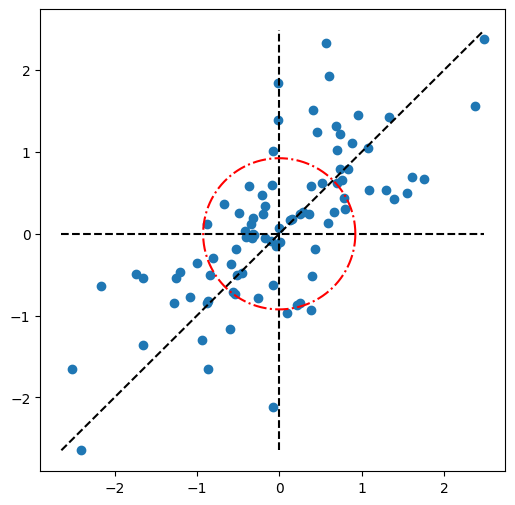

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(true_A_no_diag, reg2_coef_no_diag)
plt.plot(np.sort(np.concatenate((true_A_no_diag, reg2_coef_no_diag)))[[0,-1]], np.sort(np.concatenate((true_A_no_diag, reg2_coef_no_diag)))[[0,-1]], c="k", ls="--")
plt.plot([0, 0], np.sort(np.concatenate((true_A_no_diag, reg2_coef_no_diag)))[[0,-1]], c="k", ls="--")
plt.plot(np.sort(np.concatenate((true_A_no_diag, reg2_coef_no_diag)))[[0,-1]], [0, 0], c="k", ls="--")
theta = np.linspace(0, 2*np.pi, 1000)
plt.plot(reg2_coef_no_diag.std()*np.cos(theta), reg2_coef_no_diag.std()*np.sin(theta), c="r", ls="-.")

In [ ]:
import scipy.stats as st

In [ ]:
st.spearmanr(np.abs(reg2_coef_no_diag), np.concatenate([taros(y, dlogydt, reg2)[i, [j for j in range(n_sp) if j!=i]] for i in range(n_sp)]))

SpearmanrResult(correlation=0.5392352965386672, pvalue=4.1697950995028686e-08)

In [ ]:
print(AIC(np.concatenate((y, y2)), np.concatenate((dlogydt, dlogydt2)), reg, Sig))
print(AIC(np.concatenate((y, y2)), np.concatenate((dlogydt, dlogydt2)), reg2, Sig2))

16853023.32213465
138366.6479840501


In [ ]:
print(AICc(np.concatenate((y, y2)), np.concatenate((dlogydt, dlogydt2)), reg, Sig))
print(AICc(np.concatenate((y, y2)), np.concatenate((dlogydt, dlogydt2)), reg2, Sig2))

3074496.0474326178
188519.79783352828


In [ ]:
print(AICc(y, dlogydt, reg, Sig))
print(AICc(y, dlogydt, reg2, Sig2))

33222.735228258796
85101.13569627122


In [ ]:
print(AICc(y2, dlogydt2, reg, Sig))
print(AICc(y2, dlogydt2, reg2, Sig2))

3041562.1902066004
103707.54013949868


In [ ]:
cv_taros = []
cv_var = []
cv_score = []
cv_BIC = []
cv_AIC = []
cv_AICc = []
cv_FIM = []

# for dataset in a2["dataset"].unique():
y = a2[a2["dataset"] < 10].dropna(
)[[i for i in a2.columns if i[:2] == "sp"]].values
dlogydt = a2[a2["dataset"] < 10].dropna(
)[[i for i in a2.columns if i[:6] == "dlogsp"]].values

reg = lm.LinearRegression()
reg.fit(y, dlogydt)
Sig = (dlogydt-reg.predict(y)).var(0)

y_cv = a2[a2["dataset"] > 10].dropna(
)[[i for i in a2.columns if i[:2] == "sp"]].values
dlogydt_cv = a2[a2["dataset"] > 10].dropna(
)[[i for i in a2.columns if i[:6] == "dlogsp"]].values

cv_taros.append(np.log((taros(y_cv, dlogydt_cv, reg)).sum()))
# cv_taros.append(np.log(np.linalg.det(taros(y_cv, dlogydt_cv, reg))))
cv_var.append(((dlogydt_cv-reg.predict(y_cv))**2).mean())
cv_score.append(reg.score(y_cv, dlogydt_cv))
cv_BIC.append(BIC(y_cv, dlogydt_cv, reg, Sig))
cv_AIC.append(AIC(y_cv, dlogydt_cv, reg, Sig))
cv_AICc.append(AICc(y_cv, dlogydt_cv, reg, Sig))
cv_FIM.append(np.linalg.det(lr_fim(y_cv, dlogydt_cv, reg, Sig)))

cv_taros = np.array(cv_taros)
cv_var = np.array(cv_var)
cv_score = np.array(cv_score)
cv_BIC = np.array(cv_BIC)
cv_AIC = np.array(cv_AIC)
cv_AICc = np.array(cv_AICc)
cv_FIM = np.array(cv_FIM)

print(cv_taros.mean(), cv_taros.std())
print(cv_var.mean(), cv_var.std())
print(cv_score.mean(), cv_score.std())
print(cv_BIC.mean(), cv_BIC.std())
print(cv_AIC.mean(), cv_AIC.std())
print(cv_AICc.mean(), cv_AICc.std())
print(cv_FIM.mean(), cv_FIM.std())

4.800759782466054 0.0
0.021024552550012485 0.0
0.5812864584771325 0.0
47420.86748167546 0.0
47025.04106618564 0.0
46958.62597184601 0.0
3.2586607358819524e+213 0.0


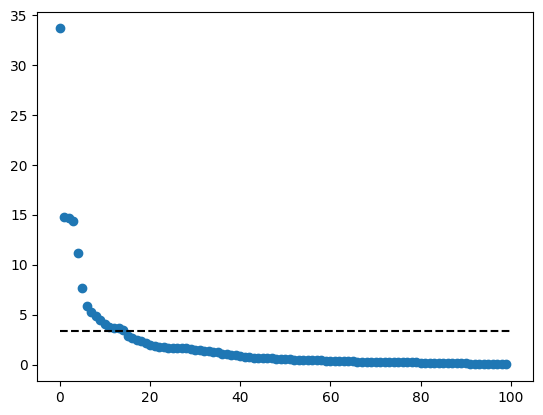

In [ ]:
plt.plot(np.sort((taros(y, dlogydt, reg).flatten()))[::-1], "o")
plt.hlines(np.sort((taros(y, dlogydt, reg).flatten()))
           [::-1].max()/10, 0, 100, color="k", ls="--")


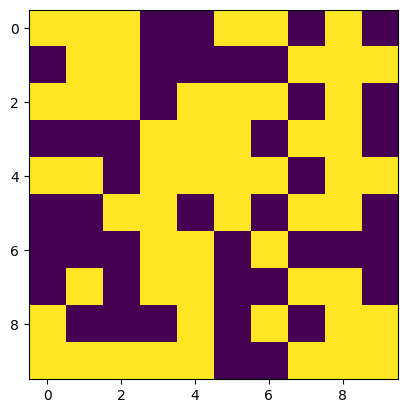

In [ ]:
plt.imshow((np.sign(true_A) == np.sign(reg.coef_)))


0.4272456332420541 0.5839126594294045


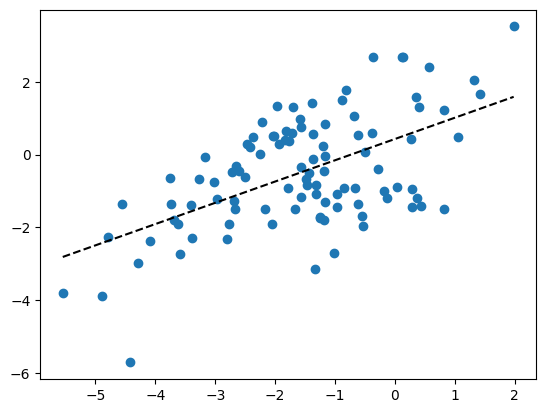

In [ ]:
plt.scatter(np.log(np.abs(reg.coef_).flatten()),
            np.log(taros(y, dlogydt, reg).flatten()))
meta_reg = lm.LinearRegression()
meta_reg.fit(np.log(np.abs(reg.coef_).flatten()).reshape(
    (-1, 1)), np.log(taros(y, dlogydt, reg).flatten()))
plt.plot(np.sort(np.log(np.abs(reg.coef_).flatten()))[[0, -1]], meta_reg.predict(np.sort(
    np.log(np.abs(reg.coef_).flatten()))[[0, -1]].reshape((-1, 1))), color="k", ls="--")

print(meta_reg.intercept_, meta_reg.coef_[0])


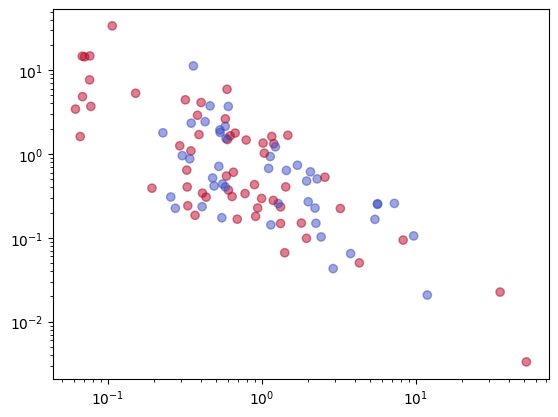

In [ ]:
plt.scatter(np.diag(cov)[n_sp:]**0.5/np.abs(reg.coef_).flatten(), taros(y, dlogydt, reg).flatten(),
            c=(np.sign(reg.coef_) == np.sign(true_A)).flatten(), cmap="coolwarm", alpha=0.5)
plt.xscale("log")
plt.yscale("log")


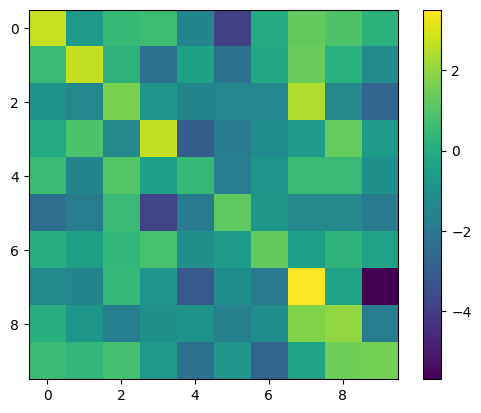

In [ ]:
plt.imshow(np.log(taros(y, dlogydt, reg).T))
plt.colorbar()
plt.show()


In [ ]:
from scipy.linalg import block_diag
import scipy.stats as st

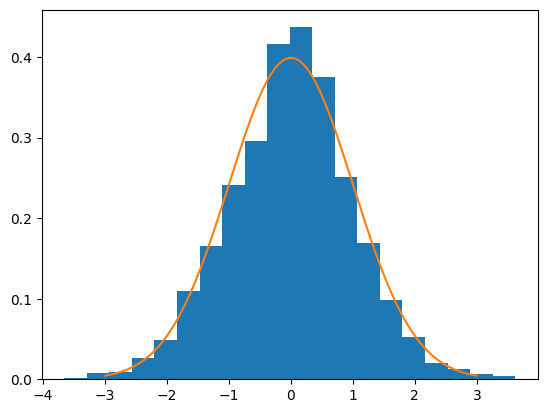

In [ ]:
plt.hist(((dlogydt-reg.predict(y))/(dlogydt-reg.predict(y)).std()
          ).flatten(), 20, density=True)
l = np.linspace(-3, 3, 1000)
plt.plot(l, st.norm.pdf(l))


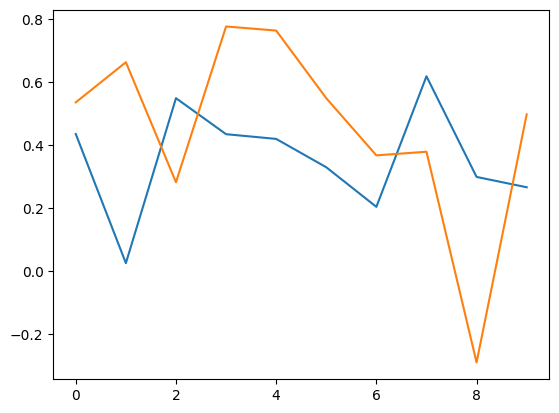

In [ ]:
plt.plot(true_params[:n_sp])
plt.plot(reg.intercept_)


In [ ]:
(np.sign(true_A) == np.sign(reg.coef_)).mean()


0.57

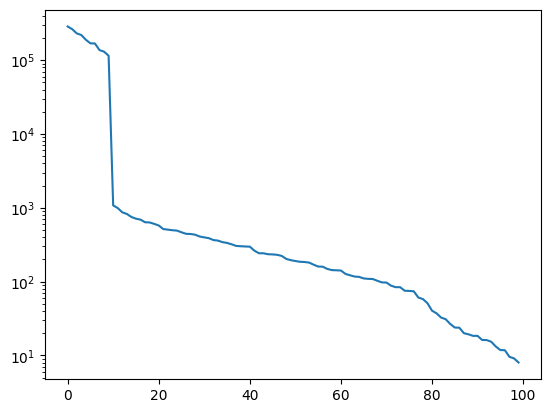

In [ ]:
plt.plot(np.sort(np.linalg.eig(F[n_sp:, n_sp:])[0])[::-1])
# plt.xscale("log")
plt.yscale("log")


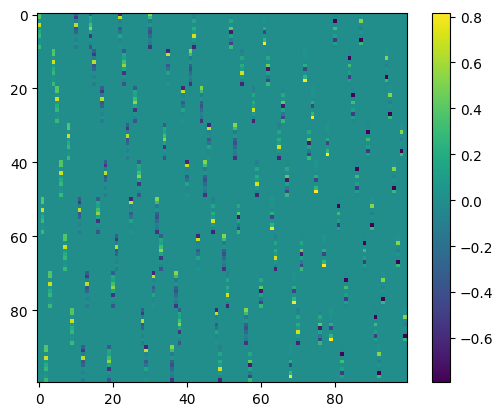

In [ ]:
plt.imshow(np.linalg.eig(F[n_sp:, n_sp:])[1][:, np.argsort(
    np.linalg.eig(F[n_sp:, n_sp:])[0])][:, ::-1])
plt.colorbar()


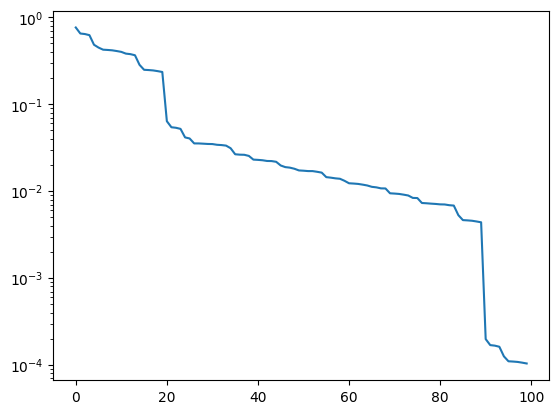

In [ ]:
plt.plot(np.sort(np.linalg.eig(cov[n_sp:, n_sp:])[0])[::-1])
# plt.xscale("log")
plt.yscale("log")


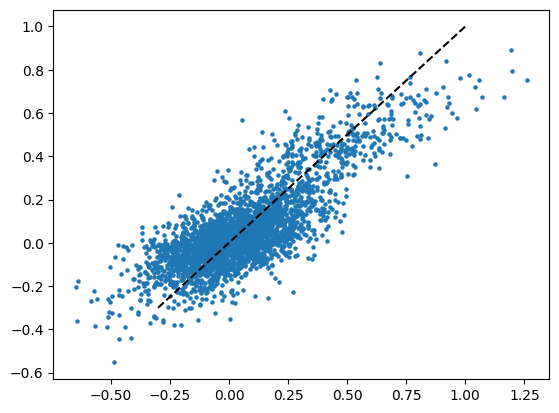

In [ ]:
plt.scatter(dlogydt, reg.predict(y), s=5)
plt.plot([-0.3, 1], [-0.3, 1], ls="--", c="k")


In [ ]:
(np.sign(true_A) == np.sign(reg.coef_)).mean()


0.57

(array([0.03696031, 0.07392061, 0.07392061, 0.40656338, 0.22176184,
        0.29568245, 0.14784123, 0.22176184, 0.07392061, 0.03696031]),
 array([-3.87371482, -3.2445043 , -2.61529378, -1.98608325, -1.35687273,
        -0.72766221, -0.09845169,  0.53075883,  1.15996935,  1.78917987,
         2.4183904 ]),
 [<matplotlib.patches.Polygon at 0x7fbcfc04f8b0>])

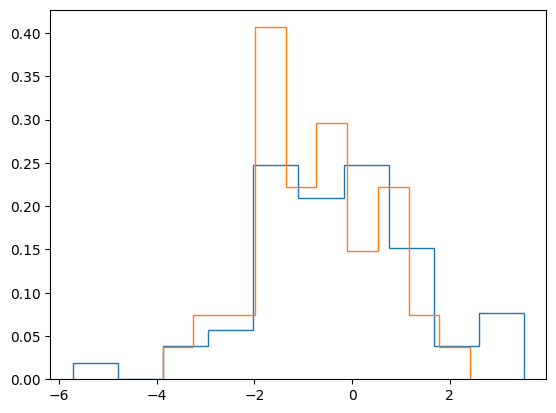

In [ ]:
plt.hist(np.log(taros(y, dlogydt, reg)).flatten()[
         (np.sign(true_A) == np.sign(reg.coef_)).flatten()], histtype="step", density=True)
plt.hist(np.log(taros(y, dlogydt, reg)).flatten()[
         (np.sign(true_A) != np.sign(reg.coef_)).flatten()], histtype="step", density=True)
# plt.yscale("log")


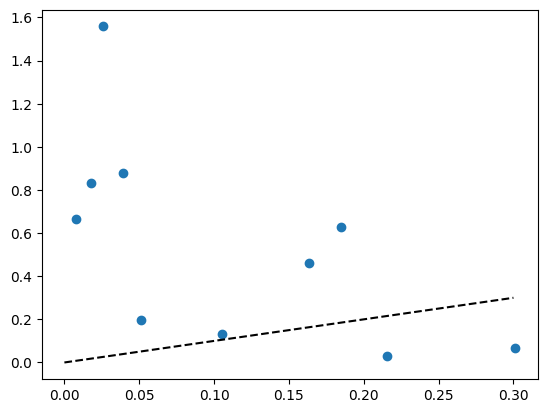

In [ ]:
plt.scatter(-np.linalg.inv(true_A)@true_r, -
            np.linalg.inv(reg.coef_)@reg.intercept_)
plt.plot([0, 0.3], [0, 0.3], c="k", ls="--")


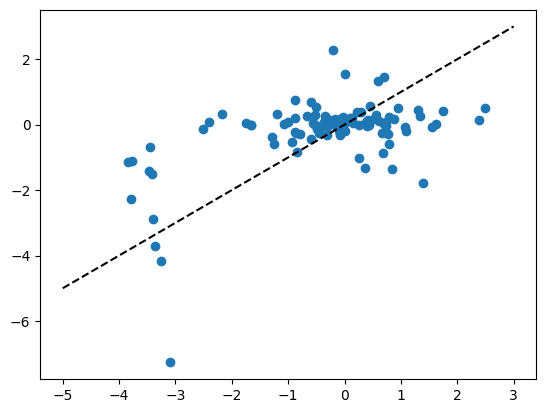

In [ ]:
plt.scatter(true_A.flatten(), reg.coef_.flatten())
plt.plot([-5, 3], [-5, 3], c="k", ls="--")


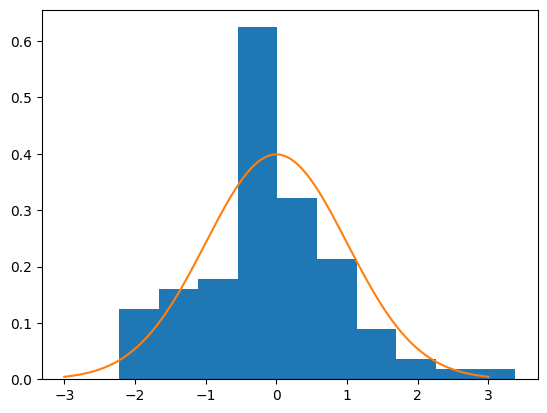

In [ ]:
import scipy.stats as st
plt.hist((true_A-reg.coef_).flatten() /
         (true_A-reg.coef_).std(), 10, density=True)
x = np.linspace(-3, 3, 1000)
plt.plot(x, st.norm.pdf(x, scale=1))


In [ ]:
(np.abs(true_A-reg.coef_).flatten()/np.diag(cov)[n_sp:]**0.5 < 0.5).mean()


0.07

<ErrorbarContainer object of 3 artists>

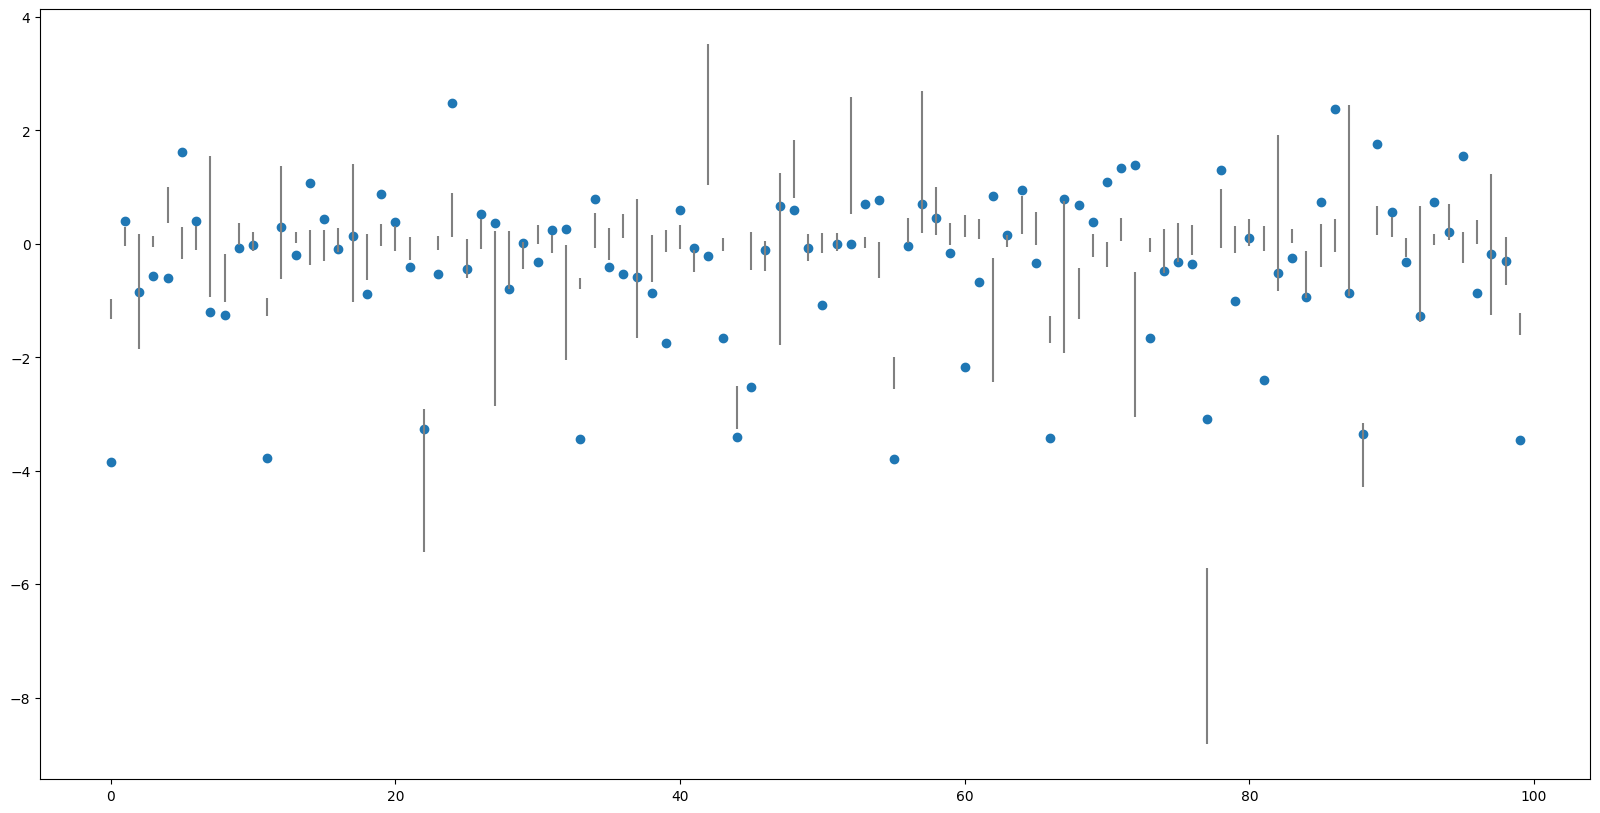

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(true_A.flatten(), "o")
# plt.plot(reg.coef_.flatten())
plt.errorbar(np.arange(n_sp**2), reg.coef_.flatten(), 2 *
             np.diag(cov)[n_sp:]**0.5, c="gray", fmt="none")
# plt.fill_between(np.arange(100), reg.coef_.flatten()-2*np.diag(cov)[n_sp:]**0.5, reg.coef_.flatten()+2*np.diag(cov)[n_sp:]**0.5, alpha=0.5, color="gray")


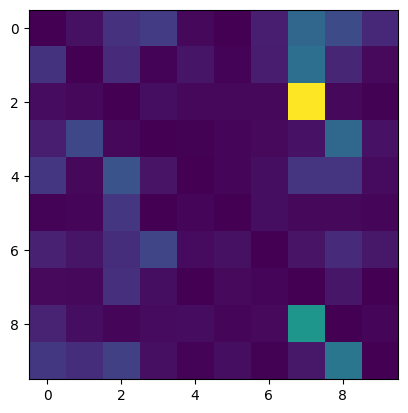

In [ ]:
plt.imshow((taros(y, dlogydt, reg)-np.eye(n_sp)*taros(y, dlogydt, reg)).T)


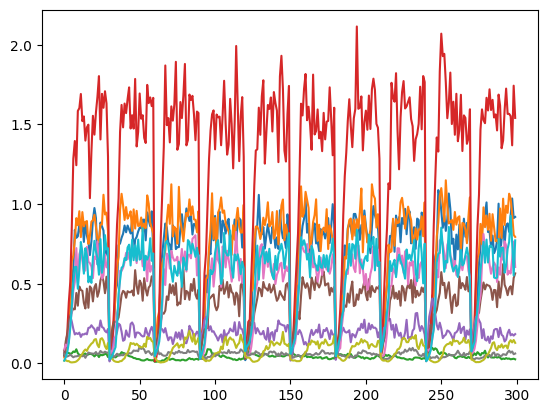

In [ ]:
plt.plot(y)

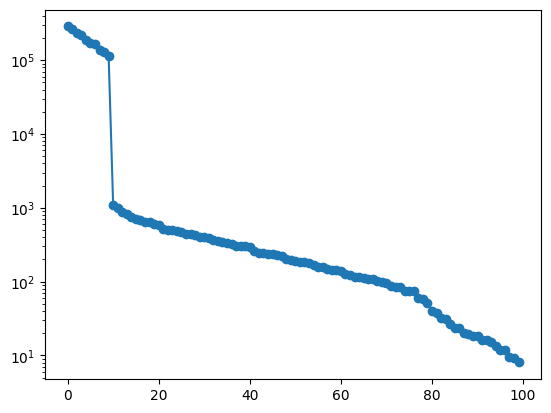

In [ ]:
plt.plot(np.sort(np.linalg.eig(F[n_sp:, n_sp:])[0])[::-1], "-o")
plt.yscale("log")

In [ ]:
corr = cov.copy()

for i in range(len(cov)):
    for j in range(len(cov)):
        corr[i, j] /= np.sqrt(cov[i, i]*cov[j, j])

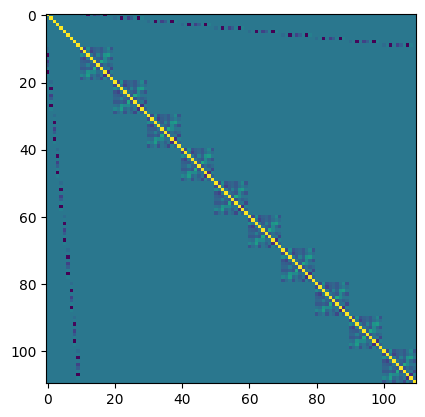

In [ ]:
plt.imshow(corr)

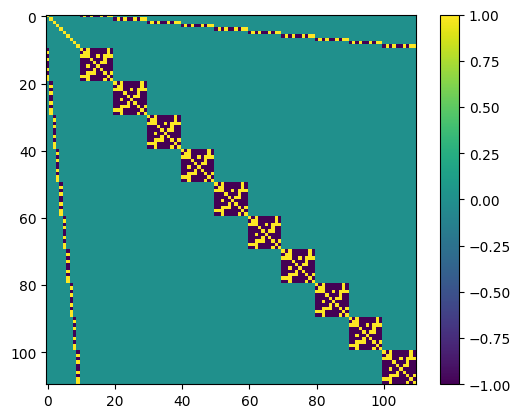

In [ ]:
cov = np.linalg.inv(lr_fim(y, dlogydt, reg, Sig))
plt.imshow(np.sign(cov))
plt.colorbar()
plt.show()

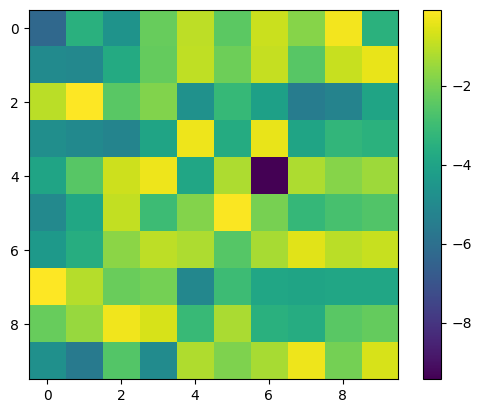

In [ ]:
plt.imshow(np.log(np.abs(np.linalg.eig(cov[n_sp:2*n_sp, n_sp:2*n_sp])[1])))
plt.colorbar()
plt.show()

---

In [ ]:
a = pd.read_csv(datafiles[0][2], index_col=0)

true_params = get_meta(open(metadatafiles[0][2]).read().split("\n"))[
    "parameters"]

true_r = true_params[:n_sp]
true_A = true_params[n_sp:].reshape((n_sp, n_sp))

add_log_time_diff(a)

reg = lm.LinearRegression()
y = a.dropna()[[i for i in a.columns if i[:2] == "sp"]].values
dlogydt = a.dropna()[[i for i in a.columns if i[:6] == "dlogsp"]].values
reg.fit(y, dlogydt)

LinearRegression()

In [ ]:
dydt = a.dropna()[[i for i in a.columns if i[:3] == "dsp"]].values
dy = dydt*a.dropna()["dt"].values.reshape((-1,1))

In [ ]:
@njit
def glv_rhs(x, p):
    n = len(x)
    r = p[:n]
    A = p[n:].reshape((n,n))
    
    return x * (r + A.dot(x))

@njit
def glv_and_grad_rhs(x, p):
    n = len(x)
    r = p[:n]
    A = p[n:].reshape((n,n))
    
    glv_rhs = x * (r + A.dot(x))

    glv_grad_rhs_x = x.reshape((-1,1))*A + np.diag(r + A@x)

    glv_grad_rhs_p = np.zeros((n, n*(n+1)))
    glv_grad_rhs_p[:n,:n] = np.diag(x)
    
    for i in range(n):
        glv_grad_rhs_p[i,n*(i+1):n*(i+2)] = x[i]*x

    return glv_rhs, glv_grad_rhs_x, glv_grad_rhs_p

In [ ]:
@njit
def euler(f, t, x_, p, n, dt):
    x = np.copy(x_)
    
    for i in range(n):
        x += dt * f(x, p)

    return x

@njit
def euler_f_and_grad(f_and_grad, t, x_, p, n, dt):
    x = np.copy(x_)
    x_grad_p = np.zeros((len(x), len(x)*(len(x)+1)))
    
    for i in range(n):
        f, f_grad_x, f_grad_p = f_and_grad(x, p)
        x += dt * f
        x_grad_p += dt * (f_grad_x@x_grad_p + f_grad_p)
        # x_grad_p += dt * f_grad_p

    return x, x_grad_p

In [ ]:
@njit
def pred(y, t, p, n):
    out = np.zeros_like(y)
    dt = np.diff(t)
    
    for i in range(len(out)):
        out[i] = euler(glv_rhs, t[i], y[i], p, n, dt[i]/n)

    return out

In [ ]:
@njit
def mse_grad(x, y, t, dt, p, n):
    s = np.zeros(x.shape[1]*(x.shape[1]+1))
    
    for i in range(x.shape[0]):
        pred, pred_grad = euler_f_and_grad(glv_and_grad_rhs, t[i], x[i], p, n, dt[i]/n)

        s += (y[i]-pred)@pred_grad

    return -2*s/(x.shape[0]*x.shape[1])

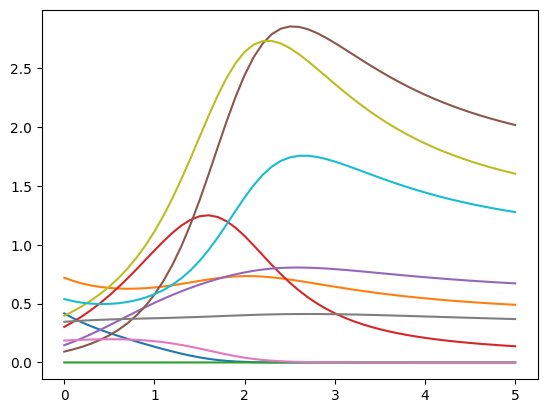

In [ ]:
n_sp = 10

np.random.seed(1)
x = np.random.uniform(0, 1, n_sp)
A = np.random.normal(0, 1, (n_sp,n_sp))
A -= np.eye(n_sp)*A + np.diag(np.abs(np.random.normal(0, 1, n_sp))*2)
C = np.random.choice([0., 1.], (n_sp, n_sp), p=[0.7, 0.3])
C -= C*np.eye(n_sp) - np.eye(n_sp)
A = A*C
r = np.random.uniform(0, 1, n_sp)
# r = -A.sum(1)

p = np.concatenate((r, A.flatten()))

t = 0.
t_hist = [t]
x_hist = [x]
dt = 0.001
n_steps = 50
n_dt = 100

for i in range(n_steps):
    x = euler(glv_rhs, t, x, p, n_dt, dt)
    t += n_dt*dt
    x_hist.append(x)
    t_hist.append(t)

x_hist = np.array(x_hist)
# x_hist += np.random.normal(0, 0.01, x_hist.shape)*x_hist
t_hist = np.array(t_hist)

plt.plot(t_hist, x_hist)
plt.show()

In [ ]:
A[0]

array([-1.4811129 , -0.7612069 ,  0.        , -0.        ,  0.        ,
       -2.06014071, -0.        , -0.        ,  0.        , -0.        ])

In [ ]:
reg.coef_[0]

array([-7.06803922e-01, -1.57451089e+00,  2.96344024e+03,  1.01043447e+00,
       -6.28060595e-01, -7.04603703e-01,  1.49934525e+00,  5.10467934e-01,
       -1.63400756e+00,  3.90580873e-01])

In [ ]:
np.corrcoef(np.hstack((np.diff(x_hist, axis=0)[:,[0]], x_hist[:-1])).T)[0,1:]

array([-0.96496874, -0.31766801, -0.42029357, -0.24581859,  0.95797494,
        0.9541548 , -0.95475904,  0.80754421,  0.86033291,  0.92161439])

In [ ]:
reg = lm.LinearRegression()
reg.fit(x_hist[:-1], np.diff(np.log(x_hist)/(n_dt*dt), axis=0))
p_ = np.concatenate((reg.intercept_, reg.coef_.flatten()))
print((np.sign(reg.coef_)==np.sign(A)).mean())

0.31


In [ ]:
@njit
def batch_sgd_rmsprop(x_hist, t_hist, p, n, alpha, gamma, eps, Eg2, n_it=1):

    for i in range(n_it):
        g = mse_grad(x_hist[:-1], x_hist[1:], t_hist, np.diff(t_hist), p, n)
        Eg2 = gamma*Eg2 + (1-gamma)*g*g
        p -= alpha/(Eg2+eps)**0.5*g

    return p, Eg2

In [ ]:
@njit
def minibatch_sgd_rmsprop(x_hist, t_hist, p, n, alpha, gamma, eps, Eg2, n_it=1, batch_size=1):
    x = x_hist[:-1]
    y = x_hist[1:]
    dt = np.diff(t_hist)
    idx = np.arange(len(x))

    for i in range(n_it):
        np.random.shuffle(idx)
        
        batch_idx = [idx[i*batch_size:(i+1)*batch_size] for i in range(len(x)//batch_size+1)]
        if len(batch_idx[-1]) < len(batch_idx[-2]):
            batch_idx[-2] = np.concatenate((batch_idx[-2], batch_idx[-1]))
        batch_idx = batch_idx[:-1]

        for j in batch_idx:
            # print(j)
            g = mse_grad(x[j], y[j], t_hist[j], dt[j], p, n)
            Eg2 = gamma*Eg2 + (1-gamma)*g*g
            p -= alpha/(Eg2+eps)**0.5*g

    return p, Eg2

In [ ]:
@njit
def minibatch_sgd_adam(x_hist, t_hist, p, n, m, v, alpha=1e-3, b1=0.9, b2=0.999, eps=1e-8, n_it=1, batch_size=1, adam_t=1):
    x = x_hist[:-1]
    y = x_hist[1:]
    dt = np.diff(t_hist)
    idx = np.arange(len(x))

    for i in range(n_it):
        np.random.shuffle(idx)
        
        batch_idx = [idx[i*batch_size:(i+1)*batch_size] for i in range(len(x)//batch_size+1)]
        if len(batch_idx[-1]) < len(batch_idx[-2]):
            batch_idx[-2] = np.concatenate((batch_idx[-2], batch_idx[-1]))
        batch_idx = batch_idx[:-1]

        for j, batch in enumerate(batch_idx):
            g = mse_grad(x[batch], y[batch], t_hist[batch], dt[batch], p, n)
            m = b1*m+(1-b1)*g
            v = b2*v+(1-b2)*g**2
            m /= 1-b1**adam_t
            v /= 1-b2**adam_t
            p -= alpha*m/(np.sqrt(v)+eps)
            adam_t += 1

    return p, m, v, adam_t

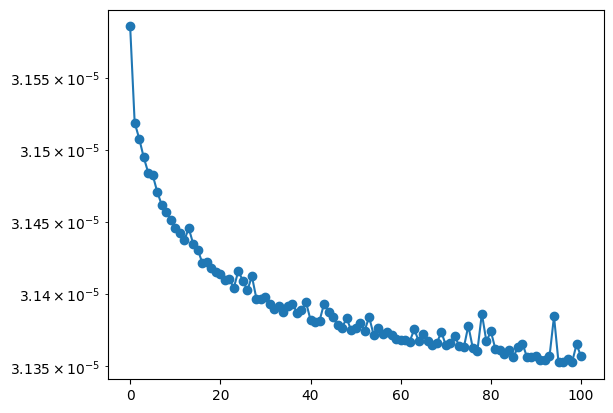

In [ ]:
# np.random.seed(2)
# p_res = np.random.normal(size=(n_sp*(n_sp+1)))
p_res = np.concatenate((reg.intercept_, reg.coef_.flatten()))
# p_res = np.random.normal(0, 1, p.shape[0])*0
# p_res = p.copy()
# p_res = np.concatenate((reg.intercept_, np.zeros(n_sp*n_sp)))

# alpha = 1e-1
gamma = 0.9
eps = 1e-7
Eg2 = np.zeros_like(p_res)

n_dt_pred = 10

alpha = 1e-3
adam_t = 1
m = np.zeros_like(p_res)
v = np.zeros_like(p_res)
b1 = 0.9
b2 = 0.999
# eps = 1e-8

mse_hist = [mse(x_hist[1:], pred(x_hist[:-1], t_hist, p_res, n_dt_pred))]
p_hist = []

for i in range(100):
    p_res, Eg2 = minibatch_sgd_rmsprop(x_hist, t_hist, p_res, n_dt_pred, alpha, gamma, eps, Eg2, 10, 1)
    # m *= 0.
    # v *= 0.
    # p_res, m, v, adam_t = minibatch_sgd_adam(x_hist, t_hist, p_res, n_dt_pred, m, v, alpha=alpha, n_it=10, batch_size=1, adam_t=adam_t)
    # m /= 1-b1**adam_t
    # v /= 1-b2**adam_t
    # adam_t += 1
    mse_hist.append(mse(x_hist[1:], pred(x_hist[:-1], t_hist, p_res, n_dt_pred)))
    p_hist.append(p_res.copy())

plt.plot(mse_hist, "-o")
plt.yscale("log")
plt.show()

In [ ]:
print((np.sign(p[n_sp:])==np.sign(reg.coef_.flatten())).mean())
print((np.sign(p[n_sp:])==np.sign(p_res[n_sp:])).mean())

0.56
0.56


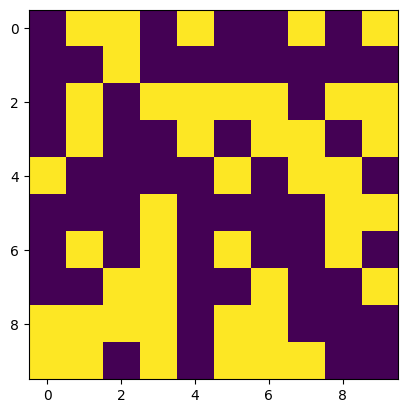

In [ ]:
plt.imshow(np.sign(p[n_sp:].reshape((n_sp,n_sp))))

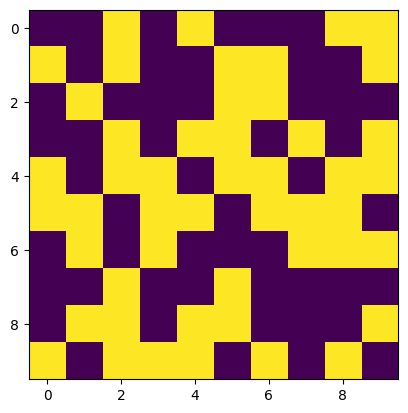

In [ ]:
plt.imshow(np.sign(reg.coef_))

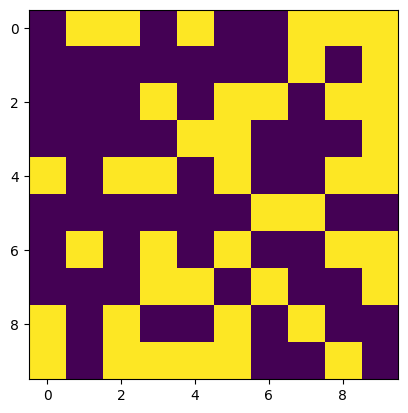

In [ ]:
plt.imshow(np.sign(p_res[n_sp:].reshape((n_sp,n_sp))))